In [37]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import datetime as dt
import sys
import os
import netCDF4
import pandas as pd
import os.path as osp
import xarray as xr
from copy import copy
from matplotlib.offsetbox import AnchoredText
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import re
from cartopy.geodesic import Geodesic
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import string
import datetime
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.io.img_tiles as cimgt
import pytz
import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
figures_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/oct2023/'

# Random Figures

In [3]:
#Load the EM27 Data
em27_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/"

dt1_str = '2022-06-27 00:00:00'
dt2_str =  '2022-06-28 00:00:00'
tz = 'US/Mountain'

oof_manage = ac.oof_manager(em27_data_folder,tz)
em27_df = oof_manage.load_oof_df_inrange(dt1_str,dt2_str,True)

/tmp/ipykernel_2227006/541962738.py:7: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['spectrum'], dtype='object')
  em27_df_rolling = em27_df.rolling(datetime.timedelta(hours=1),center=True).mean()


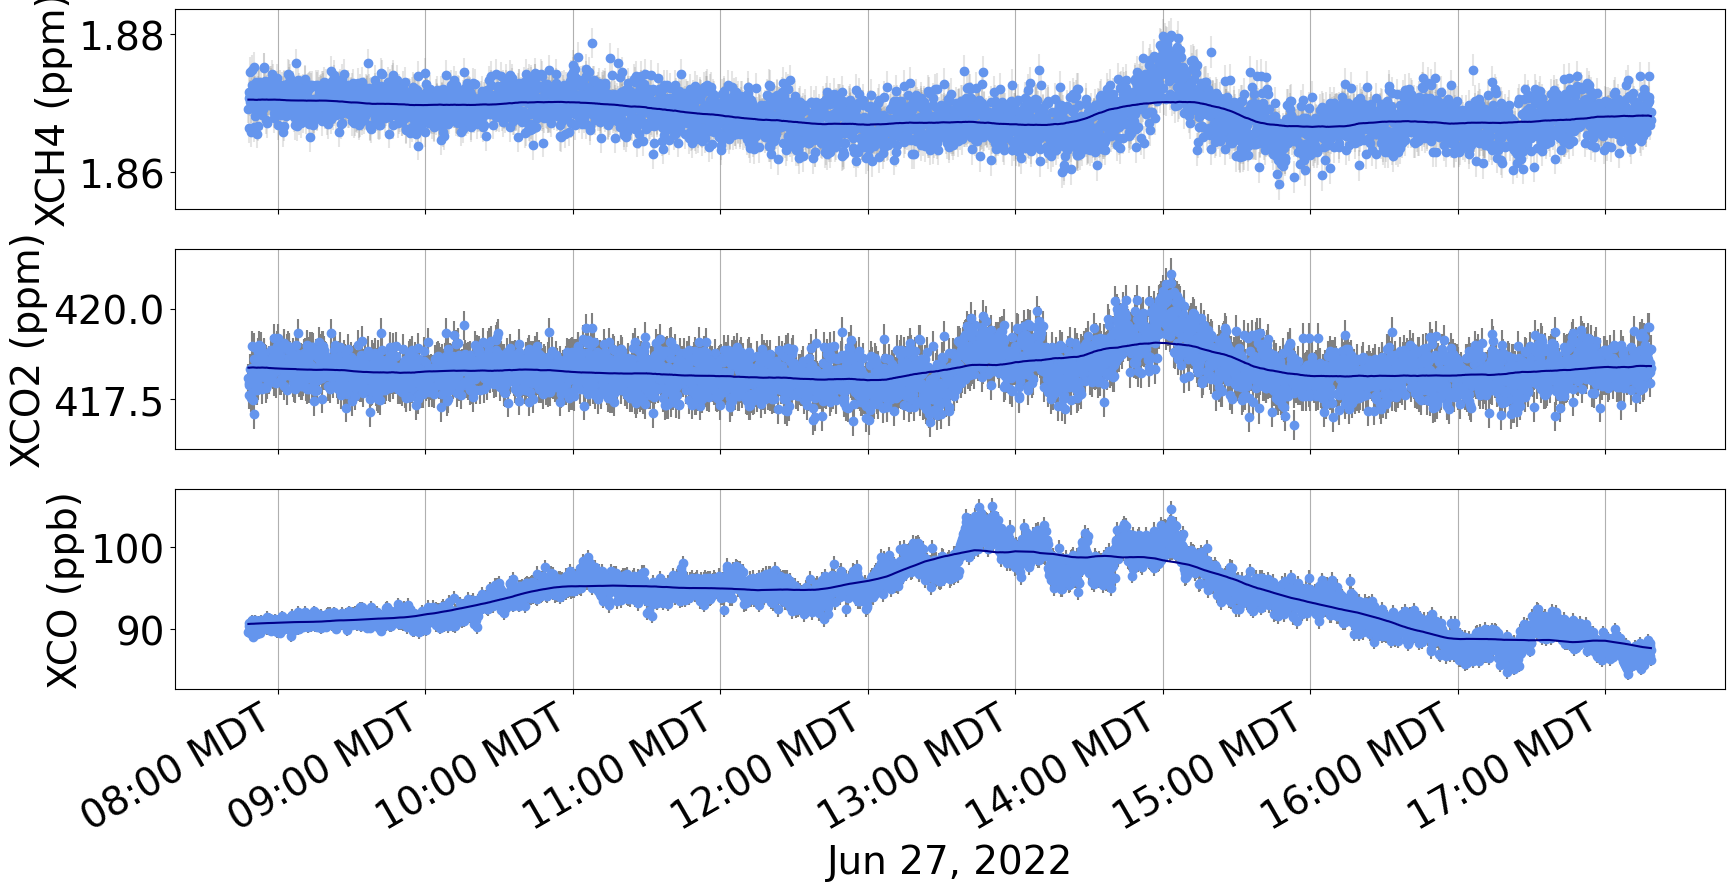

In [4]:
fig_id = 'example_single_day_ts_map'
fig,axes = plt.subplots(3,1,figsize = (20,10))
labsize = 28
before_hours = 0.5
after_hours = 0.5

em27_df_rolling = em27_df.rolling(datetime.timedelta(hours=1),center=True).mean()

xlims = [em27_df.index[0]-datetime.timedelta(hours=before_hours),em27_df.index[-1]+datetime.timedelta(hours=after_hours)]

species = 'xch4(ppm)'
axes[0].scatter(em27_df.index,em27_df[species],color = 'cornflowerblue',zorder=3,label='True Data Rate')
axes[0].errorbar(em27_df.index,em27_df[species],
                yerr=em27_df[f'{species}_error'],ls='none',
                ecolor='grey',alpha=0.2)
axes[0].plot(em27_df_rolling.index,em27_df_rolling[species],color='darkblue',zorder=4,label='1H Rolling Mean')
axes[0].tick_params(labelsize = labsize)
axes[0].set_ylabel("XCH4 (ppm)",size = labsize)
axes[0].set_xlim(xlims)
axes[0].xaxis.grid(True)
#axes[0].legend(fontsize = labsize *0.8)

species = 'xco2(ppm)'
axes[1].scatter(em27_df.index,em27_df[species],color = 'cornflowerblue',zorder=3)
axes[1].errorbar(em27_df.index,em27_df[species],
                yerr=em27_df[f'{species}_error'],ls='none',
                ecolor='grey')
axes[1].plot(em27_df_rolling.index,em27_df_rolling[species],color='darkblue',zorder=4)
axes[1].tick_params(labelsize = labsize)
axes[1].set_ylabel("XCO2 (ppm)",size = labsize)
axes[1].set_xlim(xlims)
axes[1].xaxis.grid(True)


species = 'xco(ppb)'
axes[2].scatter(em27_df.index,em27_df[species],color = 'cornflowerblue',zorder=3)
axes[2].errorbar(em27_df.index,em27_df[species],
                yerr=em27_df[f'{species}_error'],ls='none',
                ecolor='grey')
axes[2].plot(em27_df_rolling.index,em27_df_rolling[species],color='darkblue',zorder=4)
axes[2].tick_params(labelsize = labsize)
axes[2].set_ylabel('XCO (ppb)',size = labsize)
axes[2].set_xlim(xlims)
axes[2].xaxis.grid(True)


axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M %Z', tz = em27_df.index.tz))
axes[2].set_xlabel(em27_df.index[0].strftime('%b %d, %Y'),size = labsize)

plt.subplots_adjust(hspace=0.2)
plt.gcf().autofmt_xdate()

fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)
plt.show()

# Full EM27 Dataset

In [5]:
#Define parameters
base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
inst_details = {'ha':os.path.join(base_project_dir,'Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct'),
                'ua':os.path.join(base_project_dir,'Data/EM27_oof/summer_2023/elaine_retrievals/ua')}
flag = 0
resample = 'T'
timezone = 'US/Mountain' 
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']


dt1_str = '2022-05-08 11:00:00'
dt2_str = '2023-09-14 23:59:59' 

dt1 = ac.dtstr_to_dttz(dt1_str,timezone)
dt2 = ac.dtstr_to_dttz(dt2_str,timezone)
my_oof_managers = {}
oof_dfs = {}
for inst_id,path in inst_details.items():
    data_folder = os.path.join(base_project_dir,path)
    my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
    df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2)
    if flag is not None:
        df = df.loc[df['flag']==flag]
    if resample is not None:
        df = df.resample(resample).mean(numeric_only = True)
    oof_dfs[inst_id] = df.dropna(how='all')

In [17]:
good_oco_targets = ['2022-07-06',
 '2022-07-29',
 '2022-08-23',
 '2022-10-03',
 '2022-11-11',
 '2023-07-09',
 '2022-08-31',
 '2023-04-08']
good_oco_target_dts = [pd.to_datetime(x).tz_localize(timezone) for x in good_oco_targets]

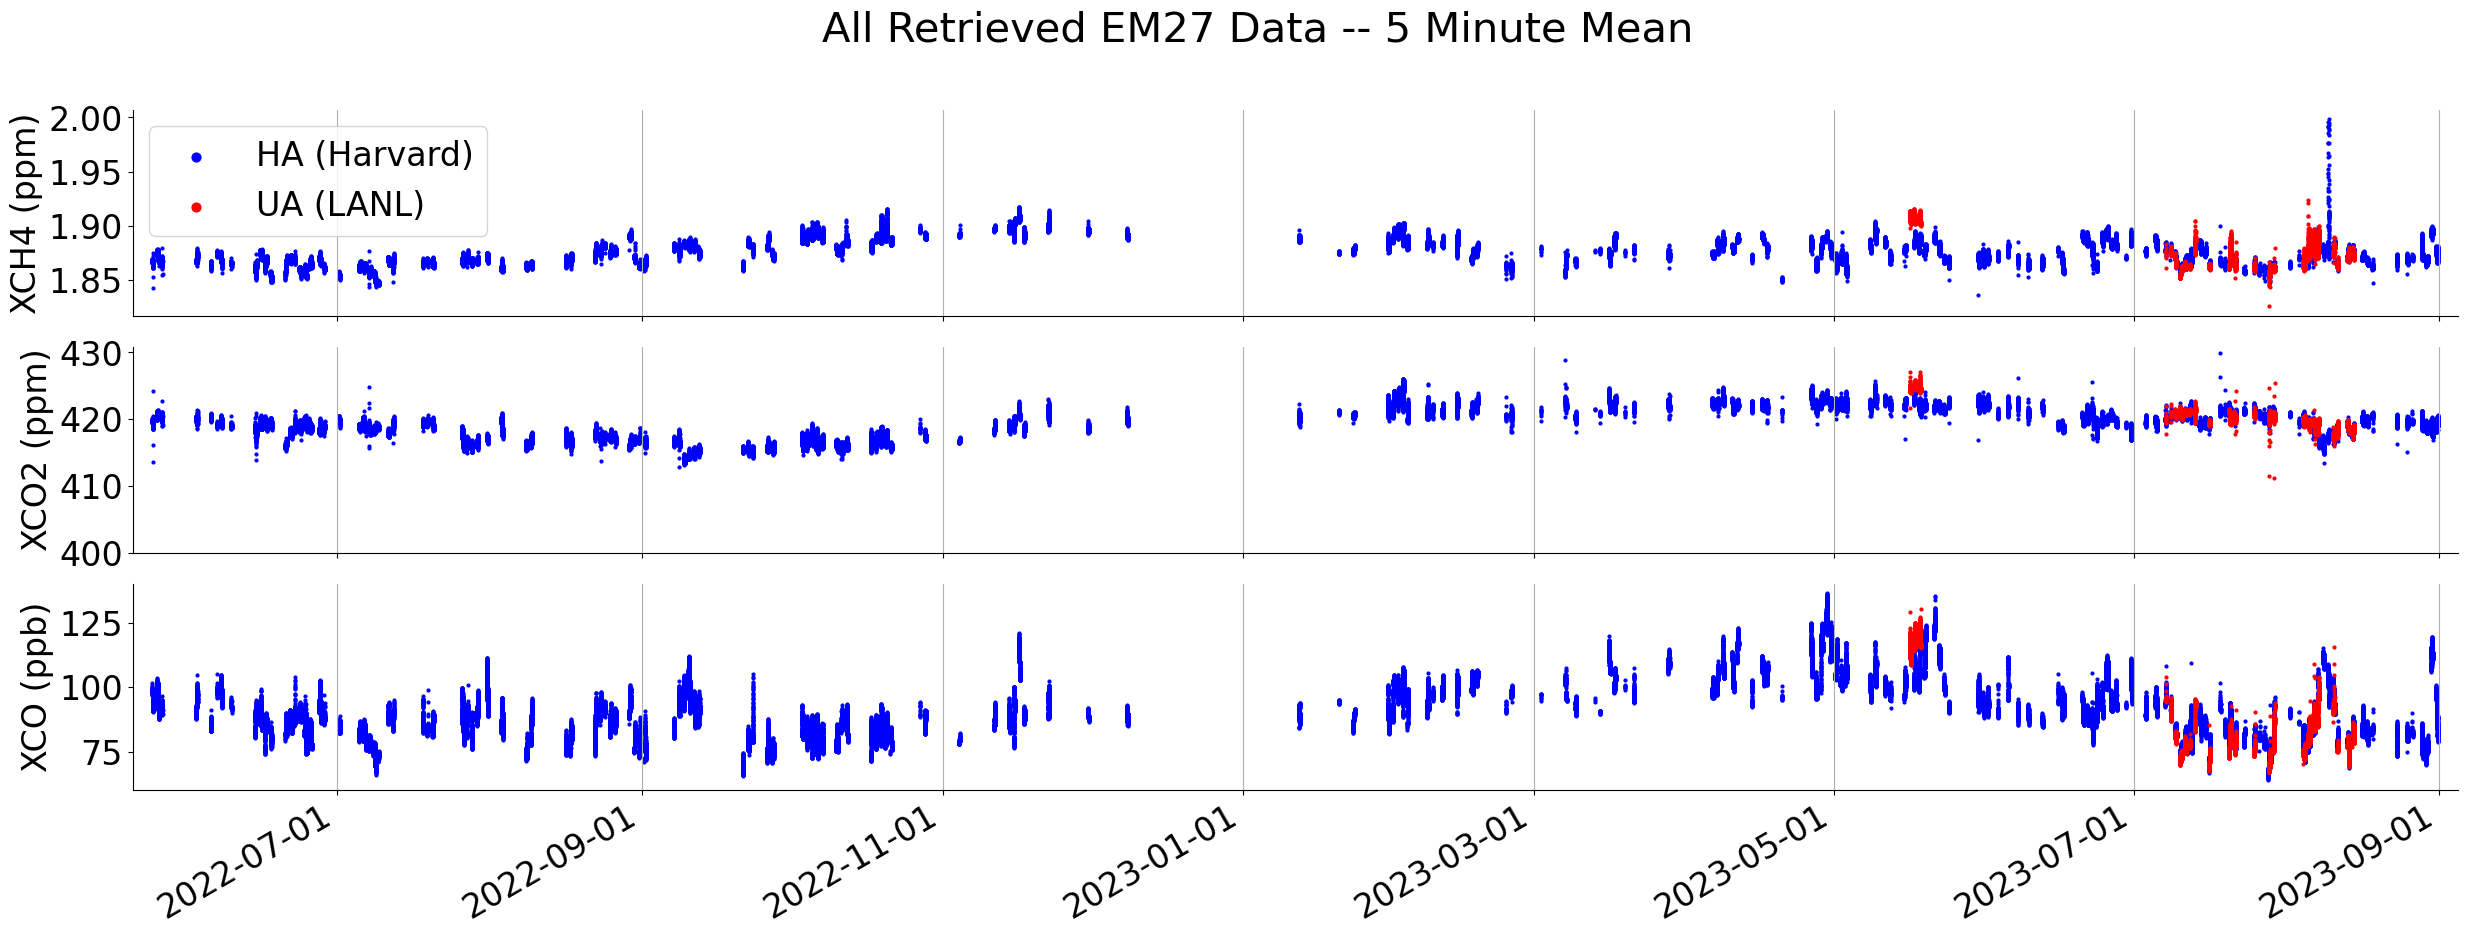

In [22]:
fig_id = 'CH4_CO2_all_ts_nooco'
savefig = True

fig,axes = plt.subplots(3,1,figsize = (30,10))
fig.suptitle('All Retrieved EM27 Data -- 5 Minute Mean',fontsize = 30)
labsize = 24
marker_size = 4

xlims = [oof_dfs['ha'].index[0]-datetime.timedelta(days=4),oof_dfs['ha'].index[-1]+datetime.timedelta(days=4)]

for inst_id in oof_dfs.keys():
    em27_resampled = oof_dfs[inst_id].copy()
    if inst_id == 'ha':
        color = 'blue'
    elif inst_id == 'ua':
        color = 'red'
        #em27_resampled = em27_resampled.loc[em27_resampled.index>'2023-07-01']
    axes[0].scatter(em27_resampled.index,em27_resampled['xch4(ppm)'],color = color,s=marker_size)
    axes[1].scatter(em27_resampled.index,em27_resampled['xco2(ppm)'],color = color,s=marker_size)
    axes[2].scatter(em27_resampled.index,em27_resampled['xco(ppb)'],color = color,s=marker_size)

axes[0].scatter([],[],label = 'HA (Harvard)',color = 'blue',s=40)
axes[0].scatter([],[],label = 'UA (LANL)',color = 'red',s=40)
axes[0].tick_params(labelsize = labsize)
axes[0].set_ylabel('XCH4 (ppm)',size = labsize)
axes[0].set_xlim(xlims)
axes[0].set_yticks([1.85,1.90,1.95,2.0])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].xaxis.grid(True)
axes[0].legend(fontsize = labsize)

axes[1].tick_params(labelsize = labsize)
axes[1].set_ylabel('XCO2 (ppm)',size = labsize)
axes[1].set_xlim(xlims)
axes[1].set_yticks([400,410,420,430])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].xaxis.grid(True)

axes[2].tick_params(labelsize = labsize)
axes[2].set_ylabel('XCO (ppb)',size = labsize)
axes[2].set_xlim(xlims)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].xaxis.grid(True)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz = em27_resampled.index.tz))
plt.subplots_adjust(hspace=0.15)
plt.gcf().autofmt_xdate()
plt.show()

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(figures_path,fig_name),dpi=500)


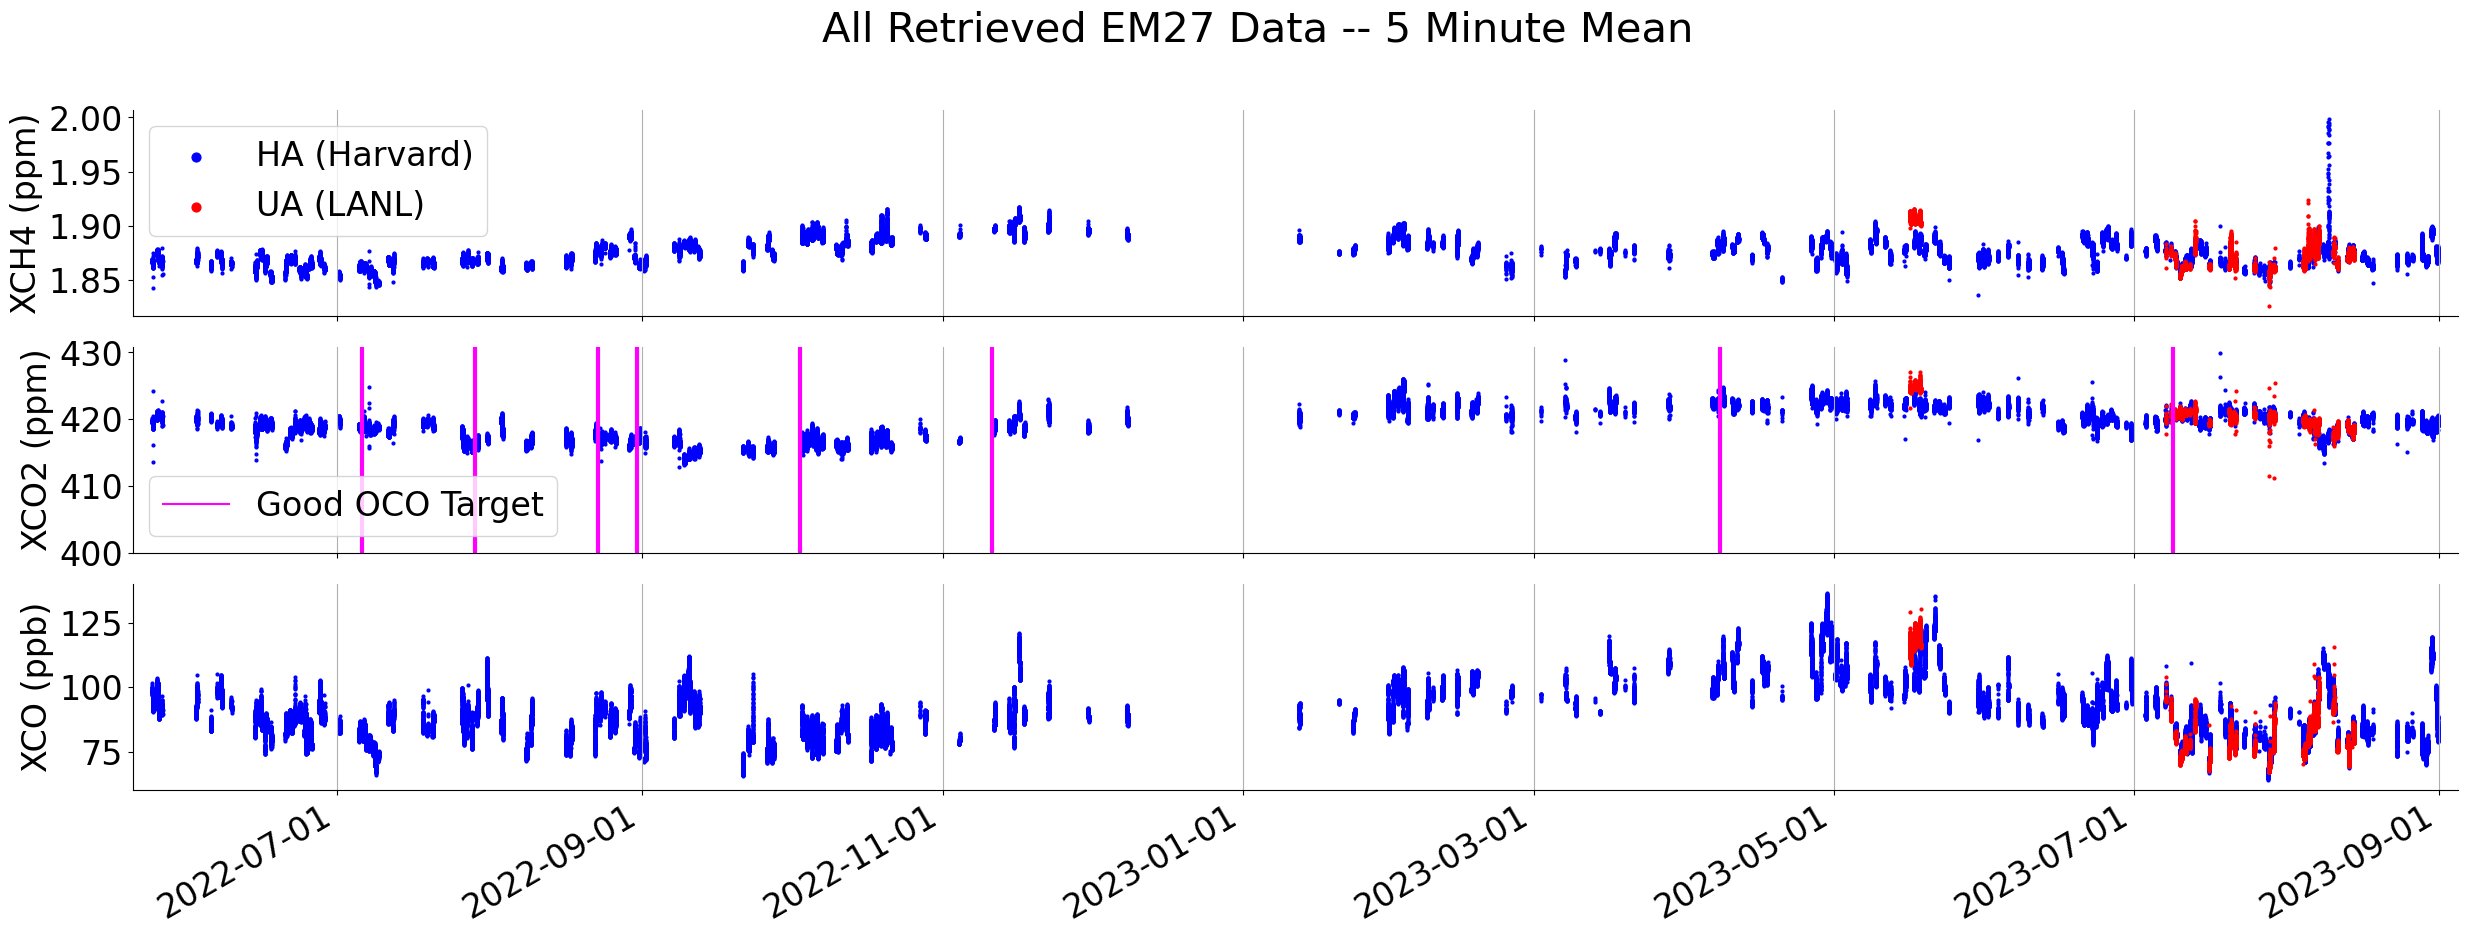

In [29]:
fig_id = 'CH4_CO2_all_ts_withoco'
savefig = True

fig,axes = plt.subplots(3,1,figsize = (30,10))
fig.suptitle('All Retrieved EM27 Data -- 5 Minute Mean',fontsize = 30)
labsize = 24
marker_size = 4

xlims = [oof_dfs['ha'].index[0]-datetime.timedelta(days=4),oof_dfs['ha'].index[-1]+datetime.timedelta(days=4)]

for inst_id in oof_dfs.keys():
    em27_resampled = oof_dfs[inst_id].copy()
    if inst_id == 'ha':
        color = 'blue'
    elif inst_id == 'ua':
        color = 'red'
        #em27_resampled = em27_resampled.loc[em27_resampled.index>'2023-07-01']
    axes[0].scatter(em27_resampled.index,em27_resampled['xch4(ppm)'],color = color,s=marker_size)
    axes[1].scatter(em27_resampled.index,em27_resampled['xco2(ppm)'],color = color,s=marker_size)
    axes[2].scatter(em27_resampled.index,em27_resampled['xco(ppb)'],color = color,s=marker_size)

for good_oco_target_dt in good_oco_target_dts:
    axes[1].axvline(good_oco_target_dt,color = 'magenta',linewidth = 3)

axes[0].scatter([],[],label = 'HA (Harvard)',color = 'blue',s=40)
axes[0].scatter([],[],label = 'UA (LANL)',color = 'red',s=40)
axes[0].tick_params(labelsize = labsize)
axes[0].set_ylabel('XCH4 (ppm)',size = labsize)
axes[0].set_xlim(xlims)
axes[0].set_yticks([1.85,1.90,1.95,2.0])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].xaxis.grid(True)
axes[0].legend(fontsize = labsize,loc=2)#,ncol = 2)

axes[1].plot([],[],label = "Good OCO Target",color = 'magenta')
axes[1].legend(fontsize = labsize,loc=3,facecolor = 'white')
axes[1].tick_params(labelsize = labsize)
axes[1].set_ylabel('XCO2 (ppm)',size = labsize)
axes[1].set_xlim(xlims)
axes[1].set_yticks([400,410,420,430])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].xaxis.grid(True)

axes[2].tick_params(labelsize = labsize)
axes[2].set_ylabel('XCO (ppb)',size = labsize)
axes[2].set_xlim(xlims)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].xaxis.grid(True)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz = em27_resampled.index.tz))
plt.subplots_adjust(hspace=0.15)
plt.gcf().autofmt_xdate()
plt.show()

if savefig:
    fig_name = f'{fig_id}.png'
    fig.savefig(os.path.join(figures_path,fig_name),dpi=500)


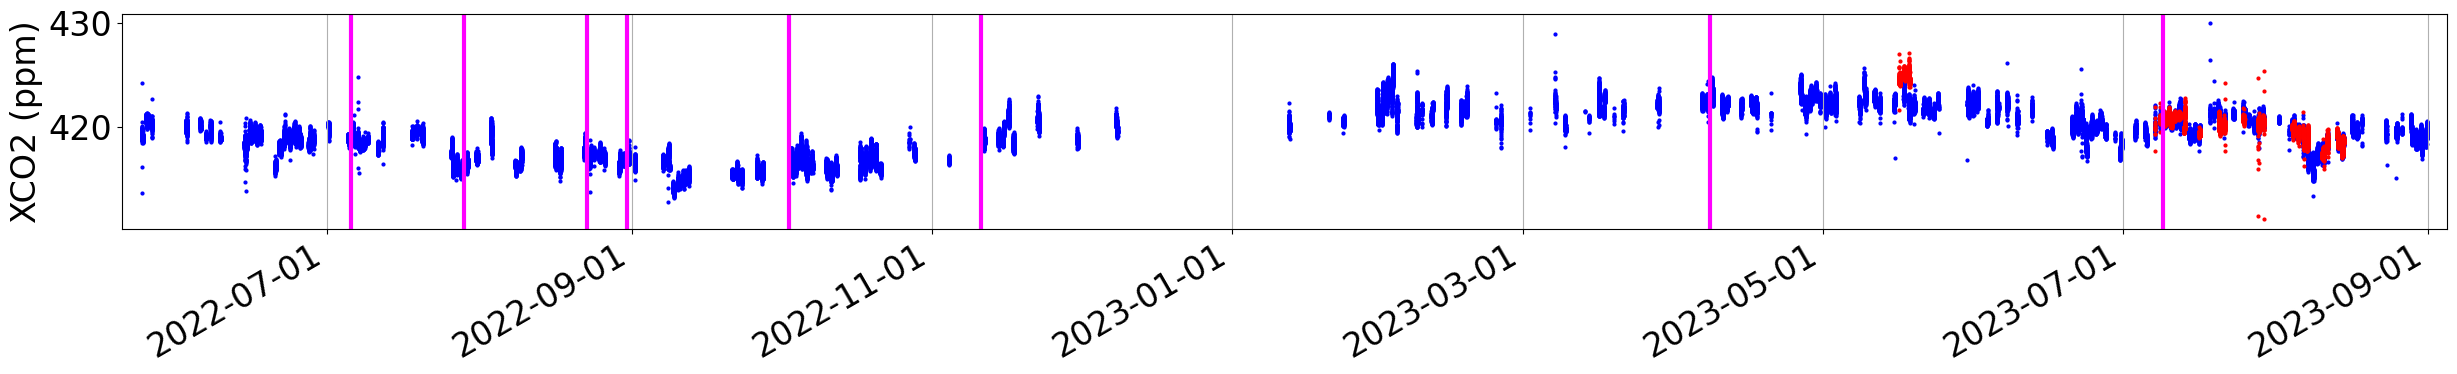

In [35]:
fig_id = 'all_em27_onlyCO2_squished_withoco'

fig,ax = plt.subplots(figsize = (30,5))
#fig.suptitle('All Retrieved EM27 Data -- 5 Minute Mean',fontsize = 30)
labsize = 24
marker_size = 4


xlims = [oof_dfs['ha'].index[0]-datetime.timedelta(days=4),oof_dfs['ha'].index[-1]+datetime.timedelta(days=4)]

for inst_id in oof_dfs.keys():
    em27_resampled = oof_dfs[inst_id].copy()
    if inst_id == 'ha':
        color = 'blue'
    elif inst_id == 'ua':
        color = 'red'
        #em27_resampled = em27_resampled.loc[em27_resampled.index>'2023-07-01']
    ax.scatter(em27_resampled.index,em27_resampled['xco2(ppm)'],color = color,s=marker_size)

for good_oco_target_dt in good_oco_target_dts:
    ax.axvline(good_oco_target_dt,color = 'magenta',linewidth = 3)
ax.scatter([],[],label = 'UA (LANL)',color = 'red',s=40)
ax.scatter([],[],label = 'HA (Harvard)',color = 'blue',s=40)
ax.tick_params(labelsize = labsize)
ax.set_ylabel('XCO2 (ppm)',size = labsize)
ax.set_xlim(xlims)
ax.xaxis.grid(True)
#ax.legend(fontsize = labsize)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz = em27_resampled.index.tz))
plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()
plt.subplots_adjust(bottom=0.45)
plt.show()

fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)


# TCCON Side-By-Side

In [60]:
#Load the EM27 Data
em27_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/summer_2023/elaine_retrievals/ua/"

dt1_str = '2023-05-16 00:00:00'
dt2_str =  '2023-05-19 10:00:00'
tz = 'UTC'

oof_manage = ac.oof_manager(em27_data_folder,tz)
em27_df = oof_manage.load_oof_df_inrange(dt1_str,dt2_str,True)

em27_df_sub = em27_df[['xch4(ppm)','xch4(ppm)_error','xco2(ppm)','xco2(ppm)_error','xco(ppb)','xco(ppb)_error']]
for col in em27_df_sub.columns:
    new_col_name = col.replace('(ppm)','')
    new_col_name = new_col_name.replace('(ppb)','')
    new_col_name = new_col_name+'_em27'
    em27_df_sub = em27_df_sub.rename(columns={col:new_col_name})

## Load the TCCON data into a dataframe

# Point to the TCCON netcdf we want to read
tccon_data_fullpath = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/TCCON/ci20230502_20230701.private.nc'
f = netCDF4.Dataset(tccon_data_fullpath)

# format the time 
time = f.variables['time']
datetimes = netCDF4.num2date(time[:], time.units)
datetimes = [date.strftime('%Y-%m-%d %H:%M:%S') for date in datetimes]

# list the variables you want to keep
cols = ['lat', 'long','xco2','xco2_error','xco','xco_error','xch4','xch4_error']

# extract those variables from the netcdf and append together
list_nc = []
for c in cols:
    list_nc.append(list(f.variables[c][:]))
    
# convert into pandas dataframe
tccon_df = pd.DataFrame(list_nc)
tccon_df = tccon_df.T # transpose the dataframe
tccon_df.columns = cols # set column names

# add the time as the dataframe index 
tccon_df.index = pd.to_datetime(datetimes, utc = True)

#trim the tccon df to the range of data in the em27 df
tccon_df_sub = tccon_df.loc[(tccon_df.index>=min(em27_df.index))&(tccon_df.index<=max(em27_df.index))]
tccon_df_sub = tccon_df_sub[['xch4','xch4_error','xco2','xco2_error','xco','xco_error']]
for col in tccon_df_sub.columns:
    new_col_name = col+'_tccon'
    tccon_df_sub = tccon_df_sub.rename(columns={col:new_col_name})

In [61]:
resample_interval = '10T'
clip_range = ['2023-05-16 20:00:00','2023-05-19 00:00:00']
em27_df_resampled = em27_df_sub.resample(resample_interval).mean(numeric_only=True)
tccon_df_resampled = tccon_df_sub.resample(resample_interval).mean(numeric_only=True)
merged_df = pd.concat([em27_df_resampled,tccon_df_resampled],axis = 1)
merged_df = merged_df.loc[(merged_df.index>=clip_range[0])&(merged_df.index<=clip_range[1])]
merged_df = merged_df.dropna()

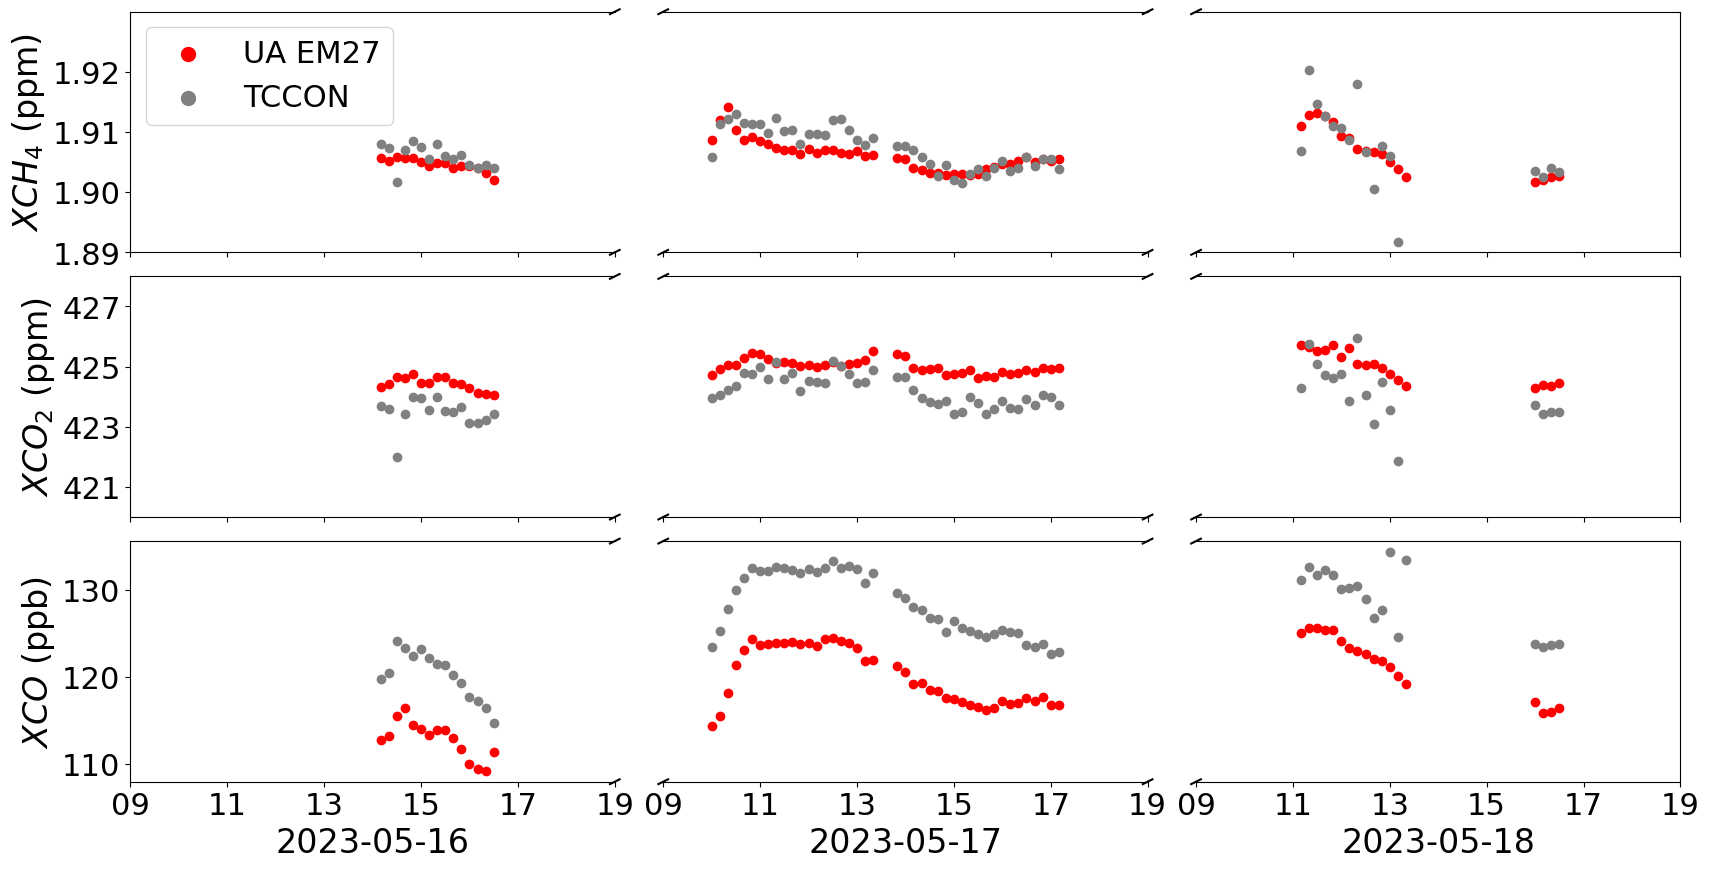

In [62]:
fig_id = 'em27_tccon_sbs'
fig,axes = plt.subplots(3,3,figsize = (20,10))
d= 0.01
plot_df = merged_df.copy()
plot_df.index = plot_df.index.tz_convert('US/Pacific')

broken_dtranges = [[pd.to_datetime('2023-05-16 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-16 18:00:00').tz_localize('US/Pacific')],
                   [pd.to_datetime('2023-05-17 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-17 18:00:00').tz_localize('US/Pacific')],
                   [pd.to_datetime('2023-05-18 08:00:00').tz_localize('US/Pacific'),pd.to_datetime('2023-05-18 18:00:00').tz_localize('US/Pacific')]]

row = 0
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4_tccon'],color = 'grey')
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    axes[row][col].set_ylim([1.89,1.93])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[0][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[0][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    axes[row][col].set_yticks([1.89,1.90,1.91,1.92]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCH_4$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 1
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2_tccon'],color = 'grey')
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])

    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
axes[row][0].set_ylabel('$XCO_2$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 2
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco_em27'],color = 'red')
    axes[row][col].scatter(plot_df.index,plot_df[f'xco_tccon'],color = 'grey')
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCO$ (ppb)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

axes[0][0].scatter([],[],color = 'red',label = 'UA EM27',s = 100)
axes[0][0].scatter([],[],color = 'grey',label = 'TCCON',s = 100)

axes[0][0].legend(fontsize = labsize-2,loc = 2)

for col in range(len(broken_dtranges)):
    axes[-1][col].tick_params(labelsize = labsize-2)
    axes[-1][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))   
    axes[-1][col].xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
    axes[-1][col].set_xlabel(broken_dtranges[col][0].strftime('%Y-%m-%d'),size =labsize)

plt.subplots_adjust(hspace=0.1,wspace = 0.1)
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)

In [63]:
specs = ['xch4','xco2','xco']
tccon_ua_diff_dict = {}
for spec in specs:
    merged_df[f'{spec}_diff'] = merged_df.apply(lambda row: row[f'{spec}_tccon']-row[f'{spec}_em27'],axis = 1)
    tccon_ua_diff_dict[spec] = dict(merged_df[f'{spec}_diff'].describe())
tccon_ua_diff_dict

{'xch4': {'count': 75.0,
  'mean': 0.002423698609672682,
  'std': 0.012280470890963922,
  'min': -0.012109092087581264,
  '25%': -0.00010854968624340877,
  '50%': 0.0014531283727505784,
  '75%': 0.0024946397729567193,
  'max': 0.10442496948242197},
 'xco2': {'count': 75.0,
  'mean': -0.5685790046311839,
  'std': 2.490528905558594,
  'min': -2.694020954000564,
  '25%': -1.0714125976562627,
  '50%': -0.835439422984166,
  '75%': -0.6018618701599507,
  'max': 20.258756103515623},
 'xco': {'count': 75.0,
  'mean': 7.876710989967739,
  'std': 1.5845583798819727,
  'min': 3.392286194918455,
  '25%': 6.978228494883616,
  '50%': 8.217048023365166,
  '75%': 8.537231456477464,
  'max': 14.173743896484382}}

# SBS EM27s

In [38]:
def merge_oofdfs(oof_dfs,dropna=False):
    inst_ids = oof_dfs.keys()
    dfs_for_merge = {}
    for inst_id in inst_ids:
        df = oof_dfs[inst_id].copy()
        for col in df.columns:
            df = df.rename(columns={col:f'{col}_{inst_id}'})
        dfs_for_merge[inst_id] = df
    merged_df = pd.DataFrame()
    for inst_id in inst_ids:
        merged_df = pd.concat([merged_df,dfs_for_merge[inst_id]],axis = 1)
    if dropna:
        merged_df = merged_df.dropna()
    return merged_df

def read_all_wbb_to_df(wbb_data_path,wbb_resample_interval):
    wbb_met_df = pd.DataFrame()
    for file in os.listdir(wbb_data_path):
        fullpath = os.path.join(wbb_data_path,file)
        df = pd.read_csv(fullpath,header = 6,skiprows=[7])
        df.index = pd.to_datetime(df['Date_Time']).dt.tz_convert(timezone)
        df[['u','v']] = df.apply(lambda row: ac.wdws_to_uv(row['wind_speed_set_1'],row['wind_direction_set_1']),axis = 1,result_type='expand')

        if wbb_resample_interval == None:
            df_resampled = df.copy()
        else:
            df_resampled = df.resample(wbb_resample_interval).mean(numeric_only=True).dropna(how='all')
        df_resampled['ws'],df_resampled['wd'] = np.vectorize(ac.uv_to_wdws)(df_resampled['u'],df_resampled['v'])
        wbb_met_df = pd.concat([wbb_met_df,df_resampled])
    wbb_met_df = wbb_met_df.sort_index()
    wbb_met_df = wbb_met_df.rename(columns={'pressure_set_1':'pressure','air_temp_set_1':'temp'})
    wbb_met_df['pressure'] = wbb_met_df['pressure']/100
    return wbb_met_df

def read_all_trisonica_to_df(trisonica_data_path,trisonica_resample_interval):
    headers_list = ['ET','Date','Time','S','D','U','V','W','T','H','DP','P','AD','PI','RO','MD','TD']
    trisonica_df = pd.DataFrame()
    for file in os.listdir(trisonica_data_path):
        fullpath = os.path.join(trisonica_data_path,file)
        with open(fullpath,'r',errors='ignore') as f:
            rows_list = []
            for i,line in enumerate(f):
                newline = line.strip()
                if len(newline) < 5:
                    continue
                newline = newline.replace('=','')
                for let in string.ascii_letters.replace('n','').replace('a',''):
                    newline = newline.replace(let,'')
                newline = newline.replace(',',' ')
                if newline[0] == ' ':
                    newline = newline[1:]
                newline = re.sub(r"\s+",",",newline)
                line_to_append = newline.split(',')
                if len(line_to_append) == len(headers_list):
                    rows_list.append(line_to_append)
            df = pd.DataFrame(rows_list)
            df.columns = headers_list
            for col in df.columns:
                df[col] = pd.to_numeric(df[col],errors='coerce')
            df = df.dropna(axis = 1,how = 'all')
            df['DT'] = pd.to_datetime(df['ET'],unit='s')
            df = df.set_index('DT')
            df.index = df.index.tz_localize('UTC').tz_convert(timezone)
            df = df.drop(['S','D'],axis = 1)
            if trisonica_resample_interval is not None:
                df = df.resample(trisonica_resample_interval).mean(numeric_only=True)
        trisonica_df = pd.concat([trisonica_df,df])
    trisonica_df = trisonica_df.sort_index()
    trisonica_df['ws'],trisonica_df['wd'] = np.vectorize(ac.uv_to_wdws)(trisonica_df['U'],trisonica_df['V'])
    return trisonica_df

In [40]:
#Define parameters
base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
data_subfolder = os.path.join(base_project_dir,'Data/EM27_oof/summer_2023/elaine_retrievals')
inst_ids = ['ha','ua']
flag = 0
resample = 'T'
timezone = 'US/Mountain' 
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']

## Without TCCON Correction

In [41]:
dt_str_ranges = [{'start':'2023-07-08 11:00:00','end':'2023-07-11 23:59:59'},
                 {'start':'2023-08-13 00:00:00','end':'2023-08-14 23:59:59'}]
my_oof_managers = {}
oof_dfs = {}
for inst_id in inst_ids:
    oof_dfs[inst_id] = pd.DataFrame()
    for dt_str_range in dt_str_ranges:
        dt1 = ac.dtstr_to_dttz(dt_str_range['start'],timezone)
        dt2 = ac.dtstr_to_dttz(dt_str_range['end'],timezone)
        data_folder = os.path.join(data_subfolder,inst_id)
        my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
        df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2)
        if flag is not None:
            df = df.loc[df['flag']==flag]
        if resample is not None:
            df = df.resample(resample).mean(numeric_only = True)
        oof_dfs[inst_id] = pd.concat([oof_dfs[inst_id],df])
merged_df = merge_oofdfs(oof_dfs,dropna=True)

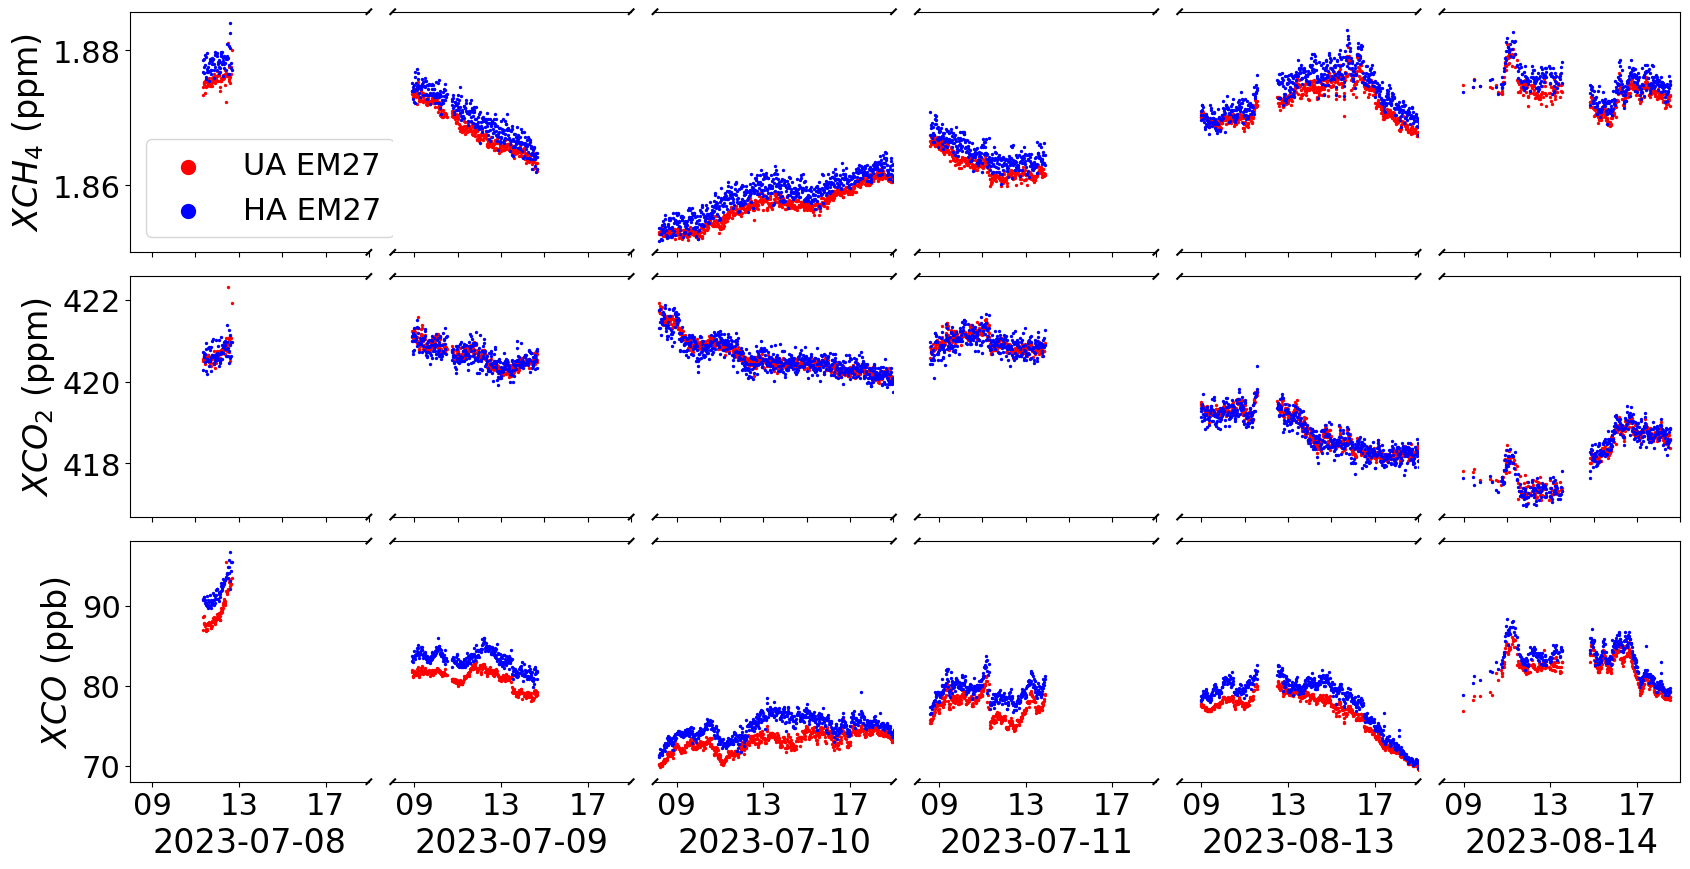

In [56]:
fig_id = 'em27_ha_ua_sbs_nocorr'
broken_dtranges = [[pd.to_datetime('2023-07-08 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-08 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-09 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-09 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-10 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-10 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-11 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-11 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-08-13 08:00:00').tz_localize(timezone),pd.to_datetime('2023-08-13 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-08-14 08:00:00').tz_localize(timezone),pd.to_datetime('2023-08-14 19:00:00').tz_localize(timezone)]]


fig,axes = plt.subplots(3,len(broken_dtranges),figsize = (20,10))
d= 0.01
markersize = 2
plot_df = merged_df.copy()


row = 0
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4(ppm)_ua'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4(ppm)_ha'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[0][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[0][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_ylim([1.89,1.93])
    #axes[row][col].set_yticks([1.89,1.90,1.91,1.92]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCH_4$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 1
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2(ppm)_ua'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2(ppm)_ha'],color = 'blue',s = markersize)
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])

    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
axes[row][0].set_ylabel('$XCO_2$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 2
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco(ppb)_ua'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xco(ppb)_ha'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCO$ (ppb)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-4)

axes[0][0].scatter([],[],color = 'red',label = 'UA EM27',s = 100)
axes[0][0].scatter([],[],color = 'blue',label = 'HA EM27',s = 100)

axes[0][0].legend(fontsize = labsize-2,loc = 3)

for col in range(len(broken_dtranges)):
    axes[-1][col].tick_params(labelsize = labsize-2)
    axes[-1][col].xaxis.set_major_locator(mdates.HourLocator(interval=4))   
    axes[-1][col].xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
    axes[-1][col].set_xlabel(broken_dtranges[col][0].strftime('%Y-%m-%d'),size =labsize)

plt.subplots_adjust(hspace=0.1,wspace = 0.1)
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)

## With TCCON Correction

In [65]:
dt_str_ranges = [{'start':'2023-07-08 11:00:00','end':'2023-07-11 23:59:59'},
                 {'start':'2023-08-13 00:00:00','end':'2023-08-14 23:59:59'}]
my_oof_managers = {}
oof_dfs = {}
for inst_id in inst_ids:
    oof_dfs[inst_id] = pd.DataFrame()
    for dt_str_range in dt_str_ranges:
        dt1 = ac.dtstr_to_dttz(dt_str_range['start'],timezone)
        dt2 = ac.dtstr_to_dttz(dt_str_range['end'],timezone)
        data_folder = os.path.join(data_subfolder,inst_id)
        my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
        df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2)
        if flag is not None:
            df = df.loc[df['flag']==flag]
        if resample is not None:
            df = df.resample(resample).mean(numeric_only = True)
        oof_dfs[inst_id] = pd.concat([oof_dfs[inst_id],df])
merged_df = merge_oofdfs(oof_dfs,dropna=True)

In [66]:
merged_df['xch4(ppm)_ua_tcconcorr'] = merged_df['xch4(ppm)_ua'] + tccon_ua_diff_dict['xch4']['50%']
merged_df['xco2(ppm)_ua_tcconcorr'] = merged_df['xco2(ppm)_ua'] + tccon_ua_diff_dict['xco2']['50%']
merged_df['xco(ppb)_ua_tcconcorr'] = merged_df['xco(ppb)_ua'] + tccon_ua_diff_dict['xco']['50%']

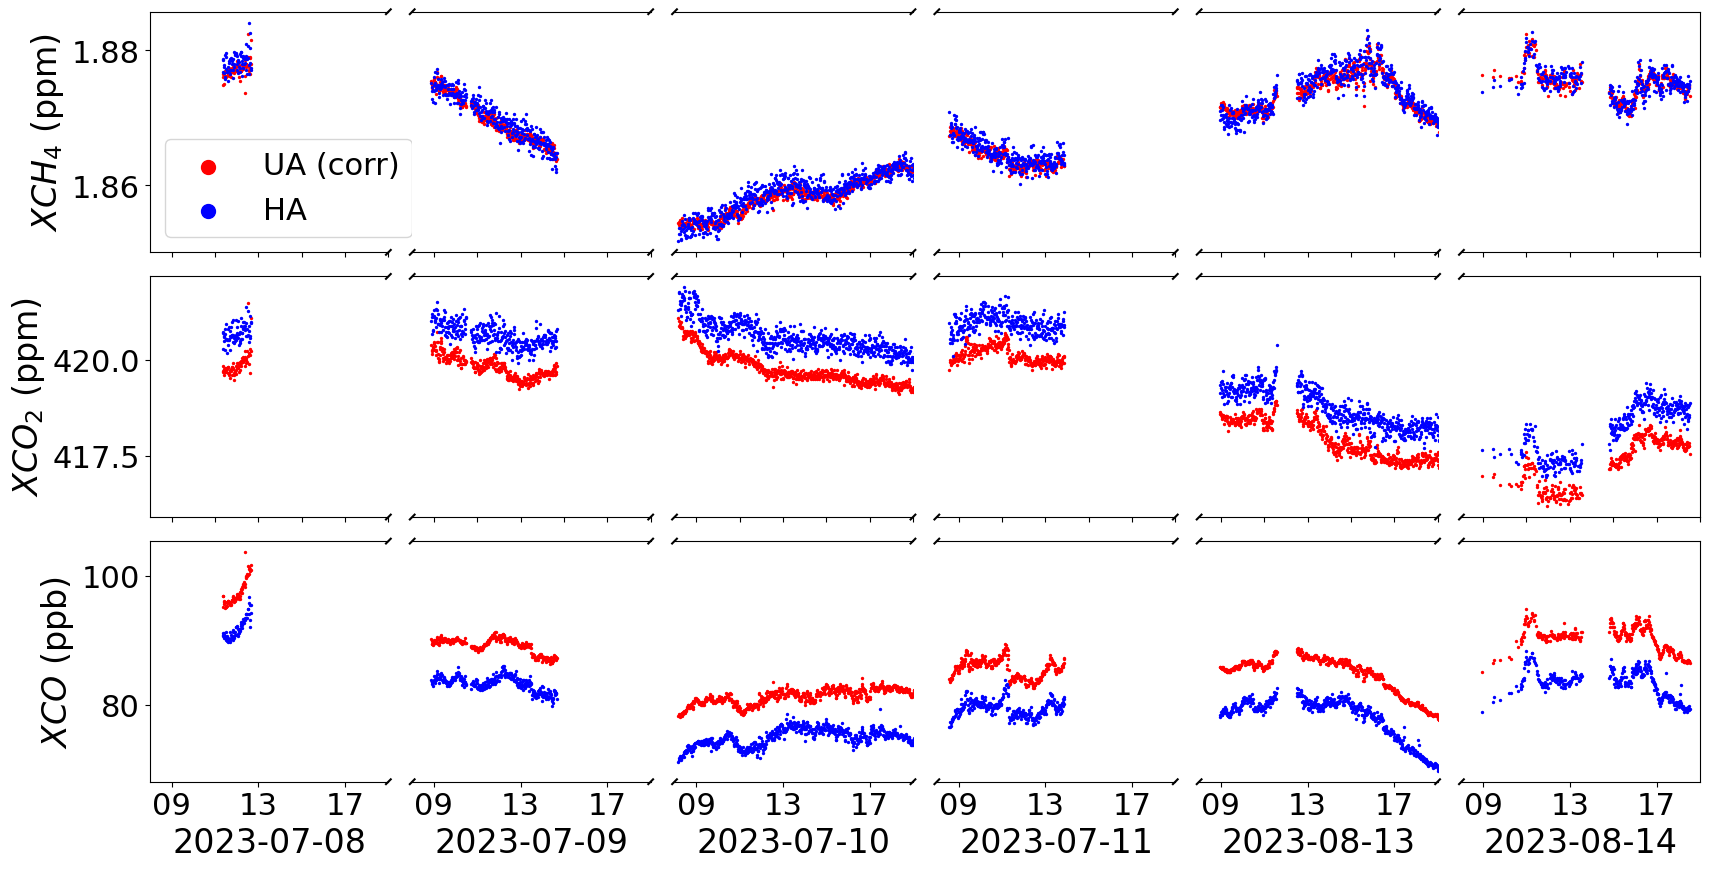

In [68]:
fig_id = 'em27_ha_ua_sbs_tcconcorr'
broken_dtranges = [[pd.to_datetime('2023-07-08 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-08 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-09 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-09 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-10 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-10 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-11 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-11 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-08-13 08:00:00').tz_localize(timezone),pd.to_datetime('2023-08-13 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-08-14 08:00:00').tz_localize(timezone),pd.to_datetime('2023-08-14 19:00:00').tz_localize(timezone)]]


fig,axes = plt.subplots(3,len(broken_dtranges),figsize = (20,10))
d= 0.01
markersize = 2
plot_df = merged_df.copy()


row = 0
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4(ppm)_ua_tcconcorr'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4(ppm)_ha'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[0][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[0][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_ylim([1.89,1.93])
    #axes[row][col].set_yticks([1.89,1.90,1.91,1.92]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCH_4$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 1
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2(ppm)_ua_tcconcorr'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2(ppm)_ha'],color = 'blue',s = markersize)
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])

    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
axes[row][0].set_ylabel('$XCO_2$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 2
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco(ppb)_ua_tcconcorr'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xco(ppb)_ha'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCO$ (ppb)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-4)

axes[0][0].scatter([],[],color = 'red',label = 'UA (corr)',s = 100)
axes[0][0].scatter([],[],color = 'blue',label = 'HA',s = 100)

axes[0][0].legend(fontsize = labsize-2,loc = 3)

for col in range(len(broken_dtranges)):
    axes[-1][col].tick_params(labelsize = labsize-2)
    axes[-1][col].xaxis.set_major_locator(mdates.HourLocator(interval=4))   
    axes[-1][col].xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
    axes[-1][col].set_xlabel(broken_dtranges[col][0].strftime('%Y-%m-%d'),size =labsize)

plt.subplots_adjust(hspace=0.1,wspace = 0.1)
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)

In [69]:
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']
ha_ua_diff_dict = {}
for spec in specs:
    merged_df[f'{spec}_diff'] = merged_df.apply(lambda row: row[f'{spec}_ua_tcconcorr']-row[f'{spec}_ha'],axis = 1)
    ha_ua_diff_dict[spec] = dict(merged_df[f'{spec}_diff'].describe())
ha_ua_diff_dict

{'xch4(ppm)': {'count': 2324.0,
  'mean': -0.00034956828121221467,
  'std': 0.001225648285042919,
  'min': -0.006546871627249429,
  '25%': -0.0011093716272492782,
  '50%': -0.00037187162724938716,
  '75%': 0.00045312837275046647,
  'max': 0.004415628372750335},
 'xco2(ppm)': {'count': 2324.0,
  'mean': -0.8268694816542209,
  'std': 0.20593594583267164,
  'min': -1.5454394229841455,
  '25%': -0.9629394229841637,
  '50%': -0.8293283118730983,
  '75%': -0.6908144229841611,
  'max': 0.8338939103490475},
 'xco(ppb)': {'count': 2324.0,
  'mean': 6.442764272716312,
  'std': 0.8211887751904423,
  'min': 3.529548023365166,
  '25%': 5.890416078920719,
  '50%': 6.493298023365156,
  '75%': 7.017048023365177,
  'max': 10.193298023365159}}

## HA corrected to UA Corr

In [71]:
dt_str_ranges = [{'start':'2023-07-08 11:00:00','end':'2023-07-11 23:59:59'},
                 {'start':'2023-08-13 00:00:00','end':'2023-08-14 23:59:59'}]
my_oof_managers = {}
oof_dfs = {}
for inst_id in inst_ids:
    oof_dfs[inst_id] = pd.DataFrame()
    for dt_str_range in dt_str_ranges:
        dt1 = ac.dtstr_to_dttz(dt_str_range['start'],timezone)
        dt2 = ac.dtstr_to_dttz(dt_str_range['end'],timezone)
        data_folder = os.path.join(data_subfolder,inst_id)
        my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
        df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2)
        if flag is not None:
            df = df.loc[df['flag']==flag]
        if resample is not None:
            df = df.resample(resample).mean(numeric_only = True)
        oof_dfs[inst_id] = pd.concat([oof_dfs[inst_id],df])
merged_df = merge_oofdfs(oof_dfs,dropna=True)

merged_df['xch4(ppm)_ua_tcconcorr'] = merged_df['xch4(ppm)_ua'] + tccon_ua_diff_dict['xch4']['50%']
merged_df['xco2(ppm)_ua_tcconcorr'] = merged_df['xco2(ppm)_ua'] + tccon_ua_diff_dict['xco2']['50%']
merged_df['xco(ppb)_ua_tcconcorr'] = merged_df['xco(ppb)_ua'] + tccon_ua_diff_dict['xco']['50%']

merged_df['xch4(ppm)_ha_tcconcorr'] = merged_df['xch4(ppm)_ha'] + ha_ua_diff_dict['xch4(ppm)']['50%']
merged_df['xco2(ppm)_ha_tcconcorr'] = merged_df['xco2(ppm)_ha'] + ha_ua_diff_dict['xco2(ppm)']['50%']
merged_df['xco(ppb)_ha_tcconcorr'] = merged_df['xco(ppb)_ha'] + ha_ua_diff_dict['xco(ppb)']['50%']

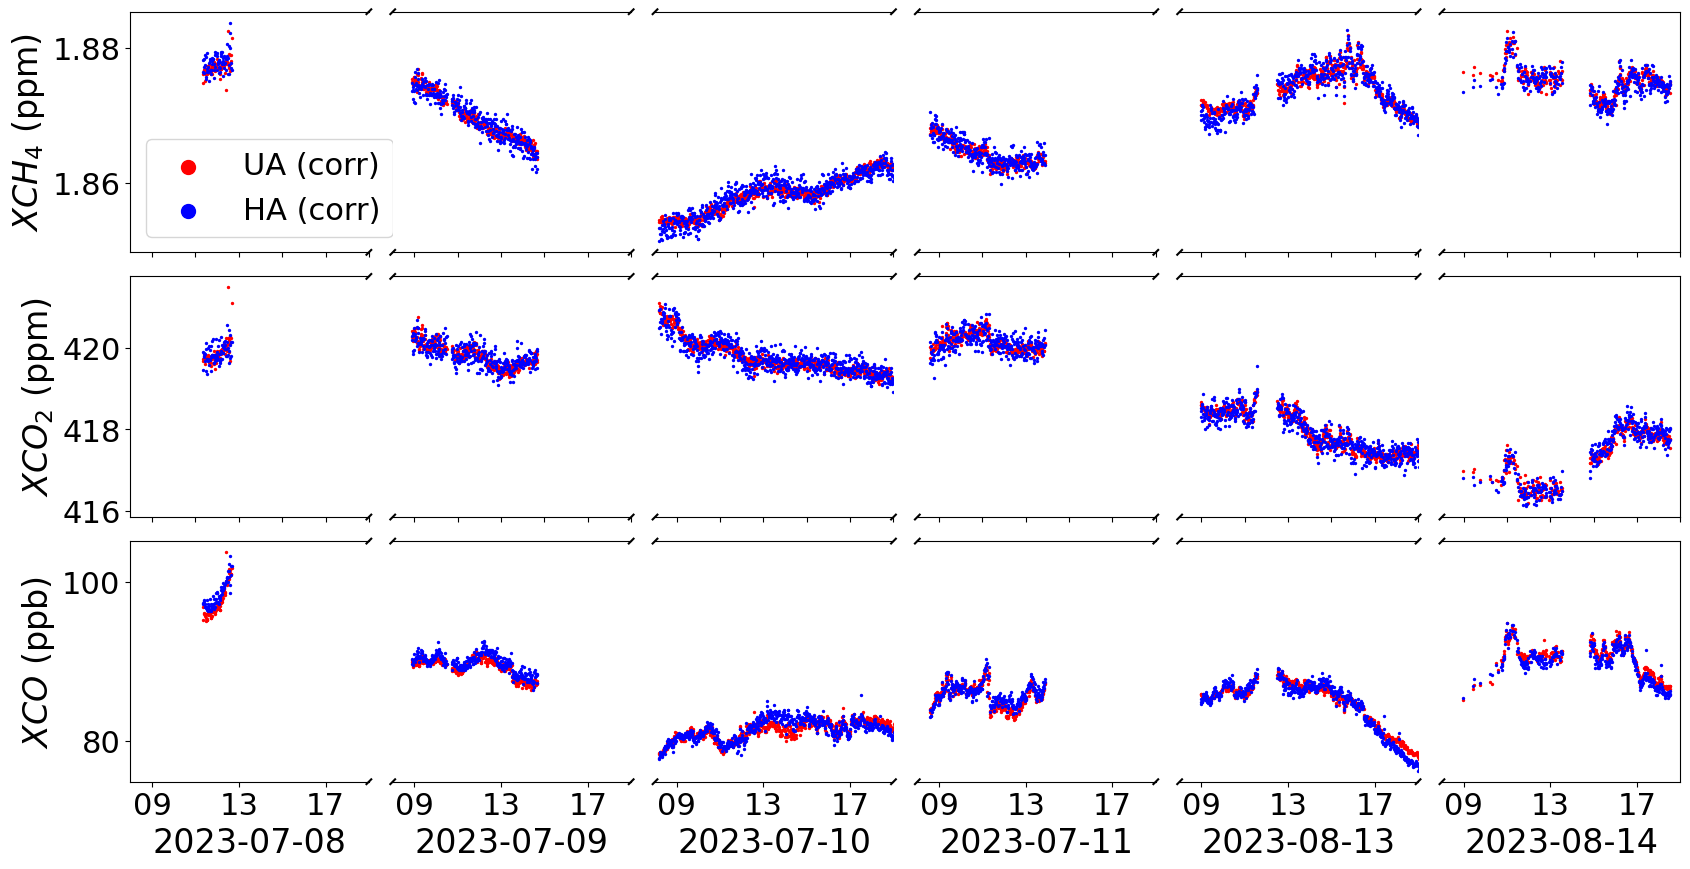

In [74]:
fig_id = 'em27_ha_ua_sbs_intercorr'
broken_dtranges = [[pd.to_datetime('2023-07-08 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-08 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-09 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-09 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-10 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-10 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-07-11 08:00:00').tz_localize(timezone),pd.to_datetime('2023-07-11 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-08-13 08:00:00').tz_localize(timezone),pd.to_datetime('2023-08-13 19:00:00').tz_localize(timezone)],
                   [pd.to_datetime('2023-08-14 08:00:00').tz_localize(timezone),pd.to_datetime('2023-08-14 19:00:00').tz_localize(timezone)]]


fig,axes = plt.subplots(3,len(broken_dtranges),figsize = (20,10))
d= 0.01
markersize = 2
plot_df = merged_df.copy()


row = 0
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4(ppm)_ua_tcconcorr'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xch4(ppm)_ha_tcconcorr'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[0][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[0][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_ylim([1.89,1.93])
    #axes[row][col].set_yticks([1.89,1.90,1.91,1.92]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCH_4$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 1
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2(ppm)_ua_tcconcorr'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xco2(ppm)_ha_tcconcorr'],color = 'blue',s = markersize)
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])

    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
axes[row][0].set_ylabel('$XCO_2$ (ppm)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-2)

row = 2
for col in range(len(broken_dtranges)):
    axes[row][col].scatter(plot_df.index,plot_df[f'xco(ppb)_ua_tcconcorr'],color = 'red',s = markersize)
    axes[row][col].scatter(plot_df.index,plot_df[f'xco(ppb)_ha_tcconcorr'],color = 'blue',s = markersize)
    if col <len(broken_dtranges)-1:
        axes[row][col].spines['right'].set_visible(False)
        axes[row][col].yaxis.tick_left()
    if col > 0:
        axes[row][col].yaxis.set_visible(False)
    #axes[row][col].set_ylim([420,428])
    if col>0:
        axes[row][col].spines['left'].set_visible(False)
        axes[row][col].yaxis.tick_right()
    if col<len(broken_dtranges)-1:
        kwargs = dict(transform=axes[row][col].transAxes, color='k', clip_on=False)
        axes[row][col].plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
        axes[row][col].plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal
    if col>0:
        kwargs.update(transform=axes[row][col].transAxes) # switch to the bottom axes
        axes[row][col].plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
        axes[row][col].plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    #axes[row][col].set_yticks([421,423,425,427]) 
    axes[row][col].get_xaxis().set_ticklabels([])
    axes[row][col].xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axes[row][col].set_xlim(broken_dtranges[col][0],broken_dtranges[col][1])
axes[row][0].set_ylabel('$XCO$ (ppb)',size = labsize)
axes[row][0].tick_params(labelsize = labsize-4)

axes[0][0].scatter([],[],color = 'red',label = 'UA (corr)',s = 100)
axes[0][0].scatter([],[],color = 'blue',label = 'HA (corr)',s = 100)

axes[0][0].legend(fontsize = labsize-2,loc = 3)

for col in range(len(broken_dtranges)):
    axes[-1][col].tick_params(labelsize = labsize-2)
    axes[-1][col].xaxis.set_major_locator(mdates.HourLocator(interval=4))   
    axes[-1][col].xaxis.set_major_formatter(mdates.DateFormatter('%H',tz='US/Mountain'))
    axes[-1][col].set_xlabel(broken_dtranges[col][0].strftime('%Y-%m-%d'),size =labsize)

plt.subplots_adjust(hspace=0.1,wspace = 0.1)
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)

# OCO Comparisons

In [79]:
def check_for_oco_file(oco_data_folder,date):
    '''Checks for an OCO file for an input date
    
    Args:
    oco_data_folder (str) : path to a directory with OCO .nc files
    date (datetime.date) : date to check for data
    
    Returns:
    oco_filename (str) : name of the oco file for that date. Returns None if there is no file.'''

    oco_date_str = datetime.datetime.strftime(date,'%y%m%d') #format the datetime to how it appears in the oco filenames (yymmdd)
    oco_filename = None #initialize to None
    for fname in os.listdir(oco_data_folder): #go through all the files in the folder
        if oco_date_str in fname: #find the file where the datestring matches one of the files
            oco_filename = fname #set the return to that file
    return oco_filename

def check_for_oof_file(oof_data_folder,date):
    '''Checks an EM27 .oof file for an input date
    
    Args:
    oof_data_folder (str) : path to a directory with EM27 .oof files
    date (datetime.date) : date to check for data
    
    Returns:
    oof_filename (str) : name of the oof file for that date. Returns None if there is no file.'''
    oof_date_str = datetime.datetime.strftime(date,'%Y%m%d') #format the date to how it appears in oof files (yyyymmdd)
    oof_filename = None
    for fname in os.listdir(oof_data_folder):
        if oof_date_str in fname:
            oof_filename = fname
    return oof_filename

def get_oco_within_radius(oco_data_folder,oco_filename,inst_loc,radius,initial_filter_deg = 1):
    xr_ds = xr.open_dataset(os.path.join(oco_data_folder,oco_filename))
    oco_df = xr_ds[['xco2','time','latitude','longitude','xco2_quality_flag']].to_dataframe().reset_index(drop=True)
    oco_df = oco_df.loc[oco_df['xco2_quality_flag']==0]
    oco_subdf = oco_df.loc[(oco_df['longitude']>=inst_loc['lon']-initial_filter_deg)&
                             (oco_df['longitude']<=inst_loc['lon']+initial_filter_deg)&
                             (oco_df['latitude']>=inst_loc['lat']-initial_filter_deg)&
                             (oco_df['latitude']<=inst_loc['lat']+initial_filter_deg)]
    if len(oco_subdf)==0:
        return None
    oco_subdf['dist_from_inst'] = np.vectorize(ac.haversine)(inst_loc['lat'],inst_loc['lon'],oco_subdf['latitude'],oco_subdf['longitude'])
    oco_subdf['inradius'] = oco_subdf.apply(lambda row: row['dist_from_inst']<=radius,axis = 1)
    oco_inradius_df = oco_subdf.loc[oco_subdf['inradius']]
    if len(oco_inradius_df)==0:
        return None
    return oco_inradius_df

def get_oco_details(oco_df):
    describe_dict = dict(oco_df['xco2'].describe())
    out_dict = {}
    for k,v in describe_dict.items():
        if k == 'count':
            out_dict['oco_num_soundings'] = v
        else:
            out_dict[f'oco_xco2_{k}'] = v
    out_dict['oco_window_start'] = pytz.timezone('UTC').localize(min(oco_df['time']))
    out_dict['oco_window_end'] = pytz.timezone('UTC').localize(max(oco_df['time']))
    return out_dict

def get_oof_within_window(oof_data_folder,oco_window_start,oco_window_end,oof_surround_time,offset_dict = None):
    oof_window_start = oco_window_start-oof_surround_time
    oof_window_end = oco_window_end+oof_surround_time
    my_oof_manager = ac.oof_manager(oof_data_folder,'UTC')
    oof_df = my_oof_manager.load_oof_df_inrange(oof_window_start,oof_window_end, filter_flag_0=True)
    if len(oof_df)==0:
        return None
    if offset_dict == None: 
        return oof_df
    for spec in offset_dict.keys():
        oof_df[spec] = oof_df.apply(lambda row: row[spec]+offset_dict[spec]['50%'],axis = 1)
    return oof_df
    
def get_oof_details(oof_df):
    describe_dict = oof_df['xco2(ppm)'].describe()
    out_dict = {}
    for k,v in describe_dict.items():
        if k == 'count':
            out_dict['em27_num_obs'] = v
        else:
            out_dict[f'em27_xco2_{k}'] = v
    return out_dict


In [80]:
oco_target_dates = {'oco2':['2022-05-10','2022-05-12','2022-06-26','2022-06-29','2022-07-06','2022-07-15','2022-07-22',
                            '2022-07-29','2022-07-31','2022-08-07','2022-08-14','2022-08-16','2022-08-23','2022-09-01',
                            '2022-09-08','2022-09-17','2022-09-24','2022-10-03','2022-10-10','2022-11-04','2022-11-11',
                            '2022-11-27','2022-11-29', '2022-12-13','2023-01-23','2023-01-30','2023-02-08','2023-02-24',
                            '2023-03-03','2023-03-19','2023-03-28','2023-04-04','2023-04-11','2023-04-13','2023-04-20',
                            '2023-04-27','2023-04-29','2023-05-06','2023-05-13','2023-05-15','2023-05-22','2023-05-29',
                            '2023-05-31','2023-06-16','2023-06-23','2023-07-02','2023-07-09','2023-07-18','2023-07-23',
                            '2023-07-25','2023-07-27','2023-08-01','2023-08-03','2023-08-10','2023-08-19','2023-08-26'],
                     'oco3':['2022-06-09','2022-08-31','2022-12-06','2023-02-05','2023-04-08','2023-05-03',
                             '2023-08-06','2023-08-09']
                     }    
oco_data_folders = {'oco2':'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/OCO/OCO2/SLC_targets/',
                    'oco3':'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/OCO/OCO3/SLC_targets/'}
oof_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/"
inst_loc = {'lat':40.768,'lon':-111.854}
radius = 6000
oof_surround_time = datetime.timedelta(minutes=30)

## With TCCON Correction

In [105]:
days_with_data = {}
for oco_type in oco_data_folders.keys():
    days_with_data[oco_type] = {}
    for oco_target_date in oco_target_dates[oco_type]:
        date = datetime.datetime.strptime(oco_target_date,'%Y-%m-%d')
        oof_filename = check_for_oof_file(oof_data_folder,date)
        oco_filename = check_for_oco_file(oco_data_folders[oco_type],date)
        if (oof_filename is not None) & (oco_filename is not None):
            days_with_data[oco_type][oco_target_date] = {'oof_filename':oof_filename,'oco_filename':oco_filename}

offset_dict = ha_ua_diff_dict

oco_em27_dicts = {}
for oco_type in oco_data_folders.keys():
    oco_em27_dicts[oco_type] = {}
    for day in days_with_data[oco_type].keys():
        oco_filename = days_with_data[oco_type][day]['oco_filename']
        oco_inradius_df = get_oco_within_radius(oco_data_folders[oco_type],oco_filename,inst_loc,radius)
        if oco_inradius_df is None:
            continue
        oco_inradius_details = get_oco_details(oco_inradius_df)
        oof_df = get_oof_within_window(oof_data_folder,oco_inradius_details['oco_window_start'],
                                        oco_inradius_details['oco_window_end'],oof_surround_time,
                                        offset_dict = offset_dict)
        if oof_df is None:
            continue

        oof_inrange_details = get_oof_details(oof_df)
        appenddict = copy(oof_inrange_details)
        appenddict.update(oco_inradius_details)
        oco_em27_dicts[oco_type][day] = appenddict

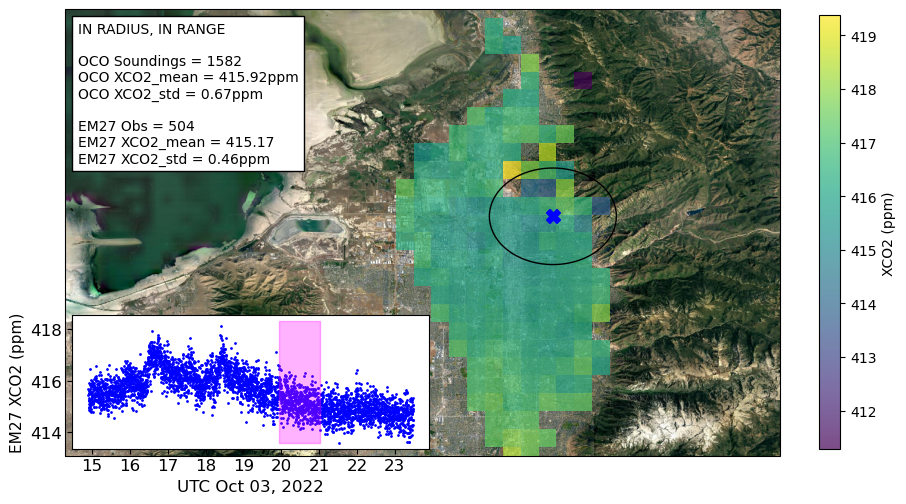

In [106]:
fig_id = 'oco_map_with_em27_corr'
map_extent=[-112.4,-111.6,40.5,41.0]
labsize = 12
proj = ccrs.PlateCarree()
request = cimgt.GoogleTiles(style='satellite')
scale = 12.0 # empirical solve for scale based on zoom
tz = 'UTC'
day = '2022-10-03'
oco_type = 'oco2'
oco_filename = days_with_data[oco_type][day]['oco_filename']
xr_ds = xr.open_dataset(os.path.join(oco_data_folders[oco_type],oco_filename))
oco_df = xr_ds[['xco2','time','latitude','longitude','xco2_quality_flag']].to_dataframe().reset_index(drop=True)
oco_df = oco_df.loc[oco_df['xco2_quality_flag']==0]
oco_subdf = oco_df.loc[(oco_df['longitude']>=map_extent[0])&
                (oco_df['longitude']<=map_extent[1])&
                (oco_df['latitude']>=map_extent[2])&
                (oco_df['latitude']<=map_extent[3])]
if len(oco_subdf)==0:
    print(f'No Data in Map Domain for {day}')
    
oco_subdf['dist_from_inst'] = np.vectorize(ac.haversine)(inst_loc['lat'],inst_loc['lon'],oco_subdf['latitude'],oco_subdf['longitude'])
oco_subdf['inradius'] = oco_subdf.apply(lambda row: row['dist_from_inst']<=radius,axis = 1)
if len(oco_subdf.loc[oco_subdf['inradius']]) == 0:
    oco_inradius_start_dt = None
    oco_inradius_end_dt = None
    oco_inradius_mean_xco2 = np.nan
    oco_inradius_std_xco2 = np.nan
    oco_inradius_num_soundings = 0
else:
    oco_inradius_start_dt = pytz.timezone(tz).localize(min(oco_subdf.loc[oco_subdf['inradius']]['time']))
    oco_inradius_end_dt = pytz.timezone(tz).localize(max(oco_subdf.loc[oco_subdf['inradius']]['time']))
    oco_inradius_mean_xco2 = oco_subdf.loc[oco_subdf['inradius']]['xco2'].mean()
    oco_inradius_std_xco2 = oco_subdf.loc[oco_subdf['inradius']]['xco2'].std()
    oco_inradius_num_soundings = len(oco_subdf.loc[oco_subdf['inradius']])

oof_filename = days_with_data[oco_type][day]['oof_filename']
my_oof_manager = ac.oof_manager(oof_data_folder,tz)
oof_df = my_oof_manager.df_from_oof(os.path.join(oof_data_folder,oof_filename),fullformat = True,filter_flag_0=True)
if offset_dict is not None:
    for spec in offset_dict.keys():
        oof_df[spec] = oof_df.apply(lambda row: row[spec]+offset_dict[spec]['50%'],axis = 1)
if oco_inradius_start_dt is None:
    oof_df['overpass_window'] = False
    intime_oof_num = 0
    intime_oof_mean_xco2 = np.nan
    intime_oof_std_xco2 = np.nan
else:
    oof_df['overpass_window'] = (oof_df.index>=oco_inradius_start_dt-oof_surround_time)&(oof_df.index<=oco_inradius_end_dt+oof_surround_time)
    intime_oof_num = len(oof_df.loc[oof_df['overpass_window']])
    intime_oof_mean_xco2 = oof_df.loc[oof_df['overpass_window']]['xco2(ppm)'].mean()
    intime_oof_std_xco2 = oof_df.loc[oof_df['overpass_window']]['xco2(ppm)'].std()

step = 0.02
to_bin = lambda x: np.floor(x/step)*step
oco_subdf['latbin'] = to_bin(oco_subdf['latitude'])
oco_subdf['lonbin'] = to_bin(oco_subdf['longitude'])
plot_xr = oco_subdf.groupby(['latbin','lonbin']).mean(numeric_only=True).to_xarray()

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.set_extent(map_extent,crs=proj)
ax.add_image(request,int(scale))

map = plot_xr['xco2'].plot.pcolormesh('lonbin','latbin',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)

ax.scatter(inst_loc['lon'],inst_loc['lat'],color = 'blue',marker = 'X',s = 100)

cp = Geodesic().circle(lon=inst_loc['lon'],lat=inst_loc['lat'],radius = radius)
geom = sgeom.Polygon(cp)
ax.add_geometries(geom,crs=proj,edgecolor = 'k',facecolor='none')

text = f"IN RADIUS, IN RANGE\n\n\
OCO Soundings = {oco_inradius_num_soundings}\n\
OCO XCO2_mean = {oco_inradius_mean_xco2:.{2}f}ppm\n\
OCO XCO2_std = {oco_inradius_std_xco2:.{2}f}ppm\n\n\
EM27 Obs = {intime_oof_num}\n\
EM27 XCO2_mean = {intime_oof_mean_xco2:.{2}f}\n\
EM27 XCO2_std = {intime_oof_std_xco2:.{2}f}ppm\
"
at = AnchoredText(text, loc='upper left', frameon=True, borderpad=0.5, prop=dict(size=10))
ax.add_artist(at)

axins = inset_axes(ax,width='50%',height='30%',loc='lower left')
axins.scatter(oof_df.index,oof_df['xco2(ppm)'],color = 'blue',zorder=3,s=1)
if oco_inradius_start_dt is not None:
    window_base = (min(oof_df.loc[oof_df['overpass_window']].index),min(oof_df['xco2(ppm)']))
    width = max(oof_df.loc[oof_df['overpass_window']].index)-min(oof_df.loc[oof_df['overpass_window']].index)
    height = max(oof_df['xco2(ppm)'])-min(oof_df['xco2(ppm)'])+0.2
    rect = mpatches.Rectangle((window_base),width,height,zorder = 10,alpha = 0.3,color = 'magenta')
    axins.add_patch(rect)
axins.tick_params(labelsize = labsize)
axins.set_ylabel('EM27 XCO2 (ppm)',size = labsize-1)
#axins.set_ylim([415,425])
axins.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz = tz))
axins.set_xlabel(oof_df.index[0].strftime('%Z %b %d, %Y'),size = labsize)
plt.gcf().autofmt_xdate()
plt.colorbar(map,fraction=0.028,label ='XCO2 (ppm)')
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)


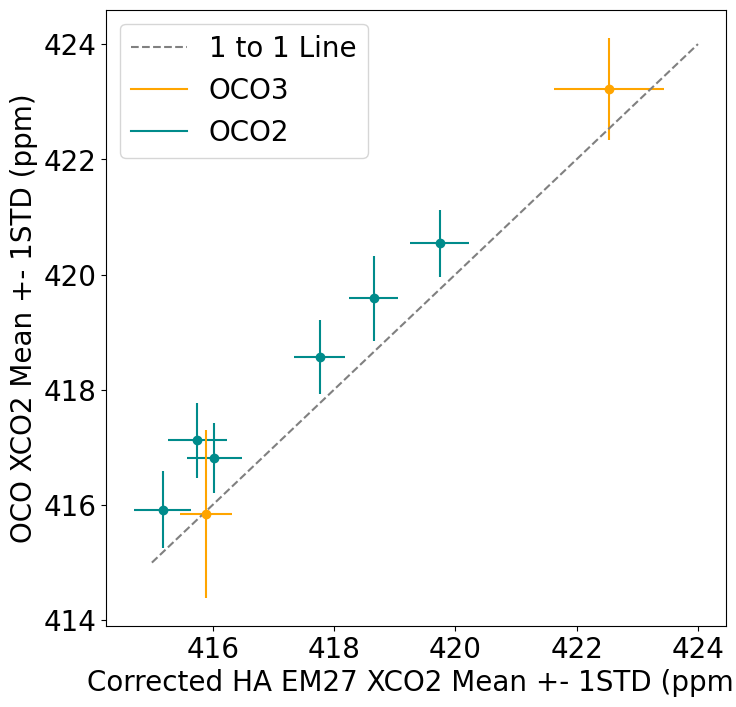

In [107]:
fig_id = 'oco2_vs_em27_corrected'
fig,ax = plt.subplots(figsize = (8,8))
labsize = 20
for oco_type in oco_em27_dicts.keys():
    oco_em27_dict = oco_em27_dicts[oco_type]
    comparison_df_oco = pd.DataFrame(oco_em27_dict).transpose()
    if oco_type =='oco2':
            color = 'darkcyan'
    else:
            color = 'orange'
    ax.errorbar(comparison_df_oco['em27_xco2_mean'],comparison_df_oco['oco_xco2_mean'],
                xerr=comparison_df_oco['em27_xco2_std'],
                yerr=comparison_df_oco['oco_xco2_std'],
                    color = color,fmt='o')
ax.plot(range(415,425),range(415,425),'--',color = 'grey',label = '1 to 1 Line')
ax.plot([],[],color = 'orange',label = 'OCO3')
ax.plot([],[],color = 'darkcyan',label='OCO2')
ax.tick_params(labelsize = labsize)
ax.set_ylabel('OCO XCO2 Mean +- 1STD (ppm)',size = labsize)
ax.set_xlabel('Corrected HA EM27 XCO2 Mean +- 1STD (ppm)',size = labsize)
ax.legend(fontsize = labsize)
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)


## NO TCCON correction

In [108]:
days_with_data = {}
for oco_type in oco_data_folders.keys():
    days_with_data[oco_type] = {}
    for oco_target_date in oco_target_dates[oco_type]:
        date = datetime.datetime.strptime(oco_target_date,'%Y-%m-%d')
        oof_filename = check_for_oof_file(oof_data_folder,date)
        oco_filename = check_for_oco_file(oco_data_folders[oco_type],date)
        if (oof_filename is not None) & (oco_filename is not None):
            days_with_data[oco_type][oco_target_date] = {'oof_filename':oof_filename,'oco_filename':oco_filename}

offset_dict = None

oco_em27_dicts = {}
for oco_type in oco_data_folders.keys():
    oco_em27_dicts[oco_type] = {}
    for day in days_with_data[oco_type].keys():
        oco_filename = days_with_data[oco_type][day]['oco_filename']
        oco_inradius_df = get_oco_within_radius(oco_data_folders[oco_type],oco_filename,inst_loc,radius)
        if oco_inradius_df is None:
            continue
        oco_inradius_details = get_oco_details(oco_inradius_df)
        oof_df = get_oof_within_window(oof_data_folder,oco_inradius_details['oco_window_start'],
                                        oco_inradius_details['oco_window_end'],oof_surround_time,
                                        offset_dict = offset_dict)
        if oof_df is None:
            continue

        oof_inrange_details = get_oof_details(oof_df)
        appenddict = copy(oof_inrange_details)
        appenddict.update(oco_inradius_details)
        oco_em27_dicts[oco_type][day] = appenddict

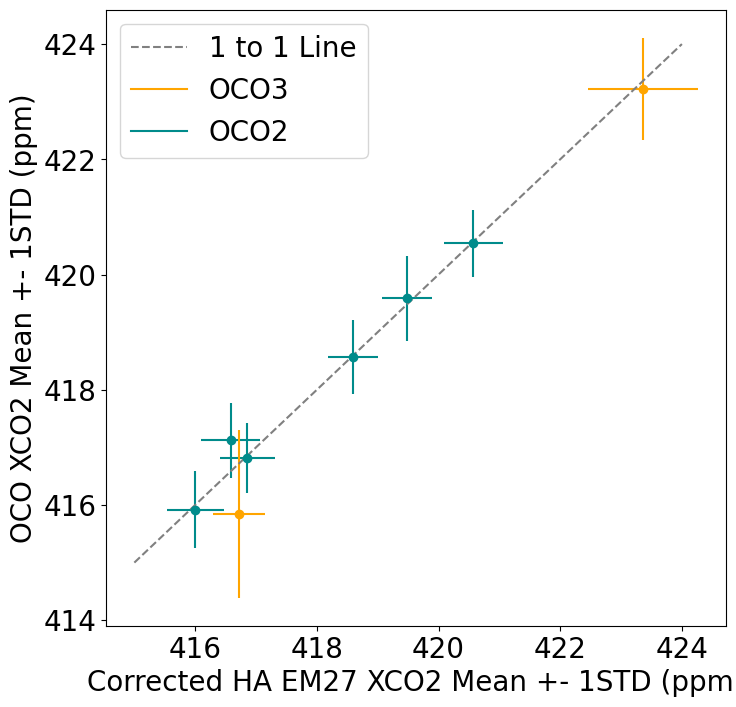

In [109]:
fig_id = 'oco2_vs_em27_notcorrected'
fig,ax = plt.subplots(figsize = (8,8))
labsize = 20

for oco_type in oco_em27_dicts.keys():
    oco_em27_dict = oco_em27_dicts[oco_type]
    comparison_df_oco = pd.DataFrame(oco_em27_dict).transpose()
    if oco_type =='oco2':
            color = 'darkcyan'
    else:
            color = 'orange'
    ax.errorbar(comparison_df_oco['em27_xco2_mean'],comparison_df_oco['oco_xco2_mean'],
                xerr=comparison_df_oco['em27_xco2_std'],
                yerr=comparison_df_oco['oco_xco2_std'],
                    color = color,fmt='o')
ax.plot(range(415,425),range(415,425),'--',color = 'grey',label = '1 to 1 Line')
ax.plot([],[],color = 'orange',label = 'OCO3')
ax.plot([],[],color = 'darkcyan',label='OCO2')
ax.tick_params(labelsize = labsize)
ax.set_ylabel('OCO XCO2 Mean +- 1STD (ppm)',size = labsize)
ax.set_xlabel('Corrected HA EM27 XCO2 Mean +- 1STD (ppm)',size = labsize)
ax.legend(fontsize = labsize)
plt.show()
fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)


# Methane

In [110]:
dt1_str = '2023-07-08 11:00:00'
dt2_str = '2023-08-14 23:59:59' 
timezone = 'US/Mountain' 
resample = '1T'
flag = 0
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)']
dt1 = ac.dtstr_to_dttz(dt1_str,timezone)
dt2 = ac.dtstr_to_dttz(dt2_str,timezone)
my_oof_managers = {}
oof_dfs = {}
for inst_id in inst_ids:
    data_folder = os.path.join(data_subfolder,inst_id)
    my_oof_managers[inst_id] = ac.oof_manager(data_folder,timezone)
    df = my_oof_managers[inst_id].load_oof_df_inrange(dt1,dt2)
    if flag is not None:
        df = df.loc[df['flag']==flag]
    if resample is not None:
        df = df.resample(resample).mean(numeric_only = True)
    oof_dfs[inst_id] = df.dropna(how='all')
merged_df = merge_oofdfs(oof_dfs)
merged_df = merged_df[['xch4(ppm)_ua','xch4(ppm)_ha','xco2(ppm)_ua','xco2(ppm)_ha','xco(ppb)_ua','xco(ppb)_ha']]

In [118]:
merged_df['xch4(ppm)_ua_tcconcorr'] = merged_df['xch4(ppm)_ua'] + tccon_ua_diff_dict['xch4']['50%']
merged_df['xco2(ppm)_ua_tcconcorr'] = merged_df['xco2(ppm)_ua'] + tccon_ua_diff_dict['xco2']['50%']
merged_df['xco(ppb)_ua_tcconcorr'] = merged_df['xco(ppb)_ua'] + tccon_ua_diff_dict['xco']['50%']

merged_df['xch4(ppm)_ha_tcconcorr'] = merged_df['xch4(ppm)_ha'] + ha_ua_diff_dict['xch4(ppm)']['50%']
merged_df['xco2(ppm)_ha_tcconcorr'] = merged_df['xco2(ppm)_ha'] + ha_ua_diff_dict['xco2(ppm)']['50%']
merged_df['xco(ppb)_ha_tcconcorr'] = merged_df['xco(ppb)_ha'] + ha_ua_diff_dict['xco(ppb)']['50%']

KeyError: 'xco2(ppm)'

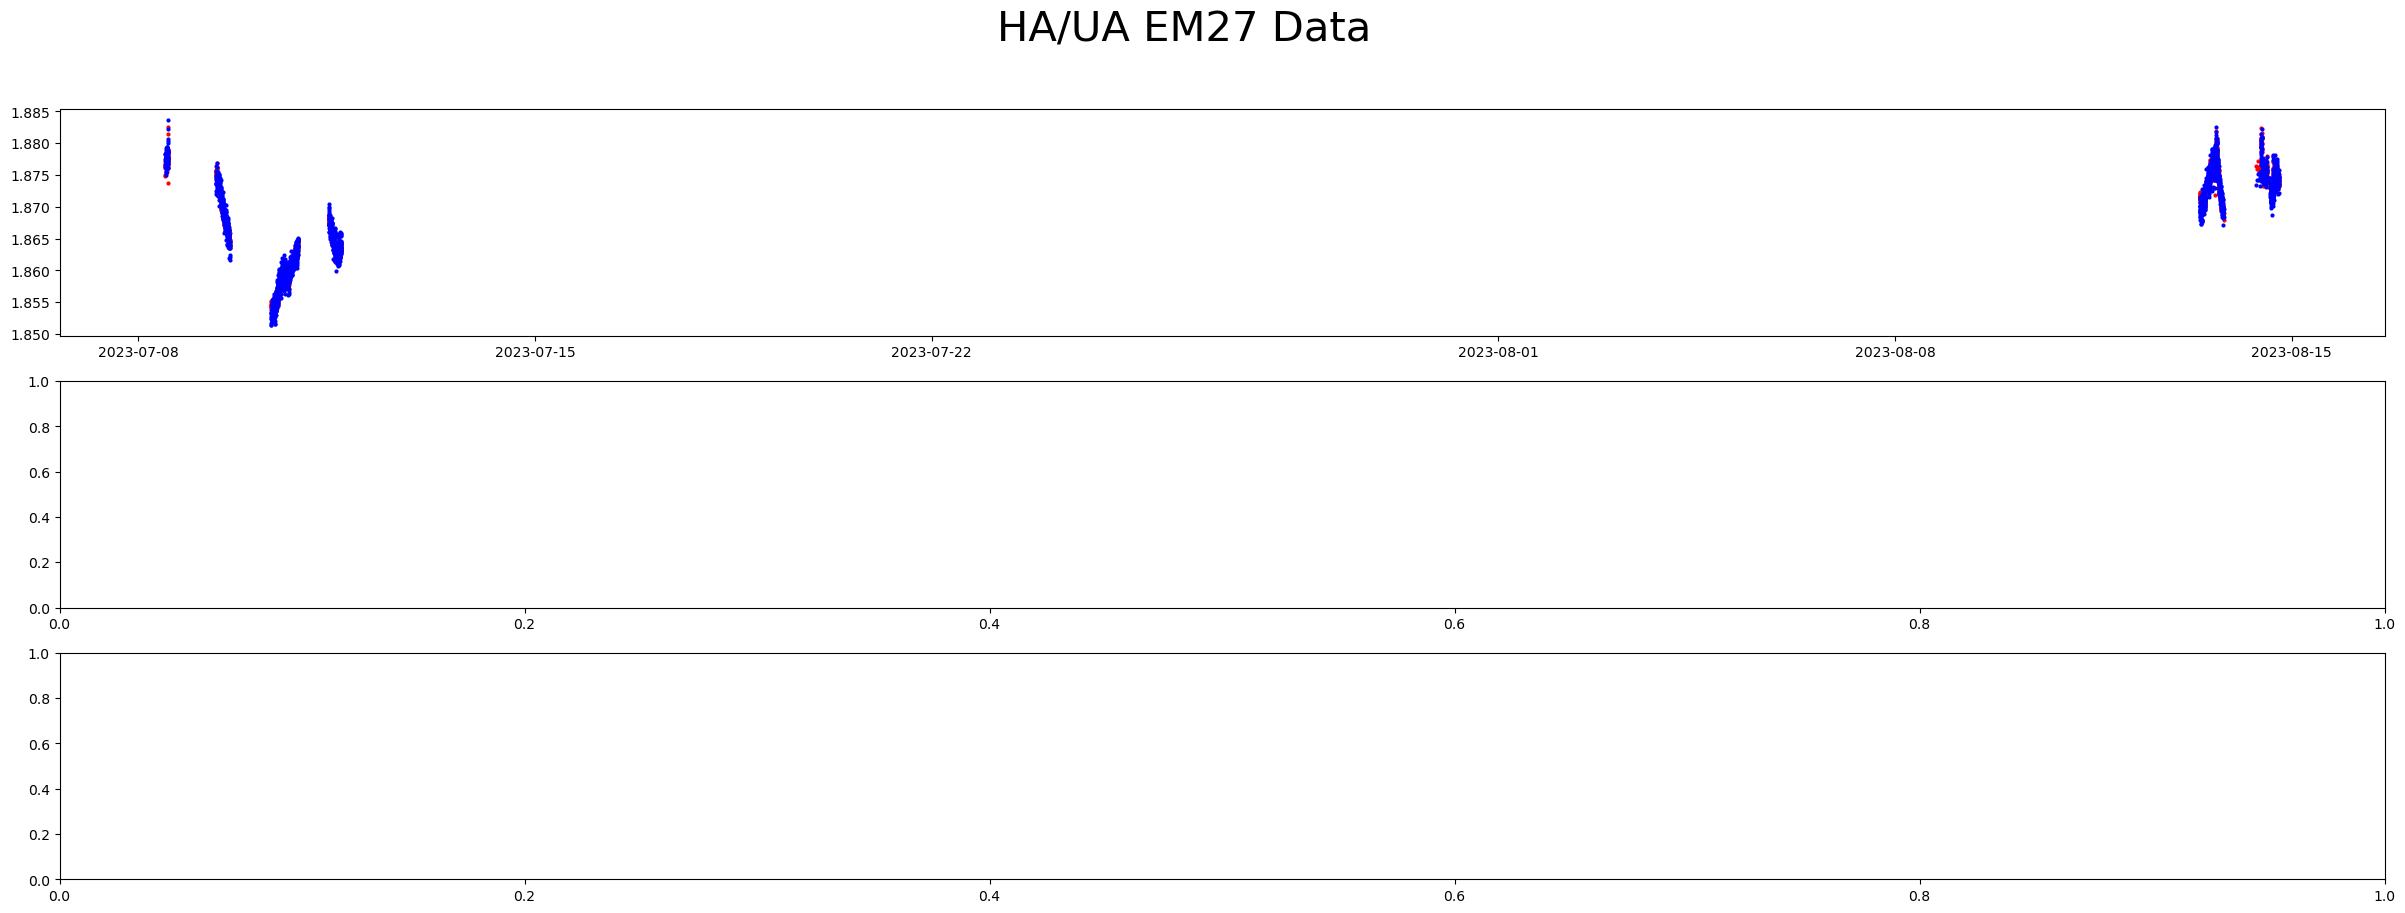

In [ ]:
fig_id = 'CH4_CO2_all_ts_corrected'

fig,axes = plt.subplots(3,1,figsize = (30,10))
fig.suptitle('HA/UA EM27 Data',fontsize = 30)
labsize = 24
marker_size = 4

xlims = [pd.to_datetime('2023-07-10 08:00:00').tz_localize('US/Mountain'),pd.to_datetime('2023-07-10 18:00:00').tz_localize('US/Mountain')]


axes[0].scatter(merged_df.index,merged_df['xch4(ppm)_ua_tcconcorr'],color = 'red',s=marker_size)
axes[0].scatter(merged_df.index,merged_df['xch4(ppm)_ha_tcconcorr'],color = 'blue',s=marker_size)

# axes[1].scatter(merged_df.index,merged_df['xco2(ppm)'],color = color,s=marker_size)
# axes[2].scatter(merged_df.index,merged_df['xco(ppb)'],color = color,s=marker_size)

axes[0].scatter([],[],label = 'HA (Harvard)',color = 'blue',s=40)
axes[0].scatter([],[],label = 'UA (LANL)',color = 'red',s=40)
axes[0].tick_params(labelsize = labsize)
axes[0].set_ylabel('XCH4 (ppm)',size = labsize)
axes[0].set_xlim(xlims)
axes[0].set_yticks([1.85,1.90,1.95,2.0])
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].xaxis.grid(True)
axes[0].legend(fontsize = labsize,loc=2)#,ncol = 2)

axes[1].tick_params(labelsize = labsize)
axes[1].set_ylabel('XCO2 (ppm)',size = labsize)
axes[1].set_xlim(xlims)
axes[1].set_yticks([400,410,420,430])
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].xaxis.grid(True)

axes[2].tick_params(labelsize = labsize)
axes[2].set_ylabel('XCO (ppb)',size = labsize)
axes[2].set_xlim(xlims)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].xaxis.grid(True)
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz = em27_resampled.index.tz))
plt.subplots_adjust(hspace=0.15)
plt.gcf().autofmt_xdate()
plt.show()

fig_name = f'{fig_id}.png'
fig.savefig(os.path.join(figures_path,fig_name),dpi=500)
